 # Video Game Sales

    Rank - Порядковое значение для количества продаж (1 - самая продаваемая игра)
    Name - Название игры.
    Platform - Платформа
    Year - Год выхода
    Genre - Жанр игры
    Publisher - Издатель
    NA_Sales - Продажи в Северной Америке (в миллионах)
    EU_Sales - Продажи в Европе (в миллионах)
    JP_Sales - Продажи в Японии (в миллионах)
    Other_Sales - Продажи в остальных регионах (в миллионах)
    Global_Sales - Суммарное количество продаж (в миллионах).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from matplotlib import pyplot as plt 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

C:\Users\mrdar\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('vgsales.csv', na_values='?')

In [3]:
df.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [4]:
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [6]:
import numpy as np
import warnings

df.fillna(np.nan,inplace = True)
df = df.replace(np.nan,'?')
def check_nans(data):
    gaps = []
    for column in data.columns:
        value = 0
        if '?' in data[column].unique():
            value = len(data[data[column] == '?'])/len(data)
        gaps.append(value)
        
    compare_props = pd.DataFrame({
    "Признаки": data.columns,
    "% пропусков": gaps,
    }).sort_index()
    return compare_props

warnings.simplefilter(action='ignore', category=Warning)
pd.reset_option('all')

check_nans(df)

,Признаки,% пропусков
0,Rank,0.000000
1,Name,0.000000
2,Platform,0.000000
3,Year,0.016327
4,Genre,0.000000
5,Publisher,0.003494
6,NA_Sales,0.000000
7,EU_Sales,0.000000
8,JP_Sales,0.000000
9,Other_Sales,0.000000


In [7]:
df = df.replace('?', np.nan)

In [8]:
print(df['Platform'].value_counts(dropna=False))
print(df['Genre'].value_counts(dropna=False))
print(df['Publisher'].value_counts(dropna=False))

DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
PSP     1213
PS      1196
PC       960
XB       824
GBA      822
GC       556
3DS      509
PSV      413
PS4      336
N64      319
SNES     239
XOne     213
SAT      173
WiiU     143
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64
Action          3316
Sports          2346
Misc            1739
Role-Playing    1488
Shooter         1310
Adventure       1286
Racing          1249
Platform         886
Simulation       867
Fighting         848
Strategy         681
Puzzle           582
Name: Genre, dtype: int64
Electronic Arts                 1351
Activision                       975
Namco Bandai Games               932
Ubisoft                          921
Konami Digital Entertainment     832
                                ... 
Glams                              1
Locus                          

In [9]:
df.drop(['Rank', 'Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1, inplace=True)
# df.drop(index=[0], axis=0, inplace=True)
df = df[df['Global_Sales'] < 80]

print(df)

      Platform    Year         Genre   Publisher  Global_Sales
1          NES  1985.0      Platform    Nintendo         40.24
2          Wii  2008.0        Racing    Nintendo         35.82
3          Wii  2009.0        Sports    Nintendo         33.00
4           GB  1996.0  Role-Playing    Nintendo         31.37
5           GB  1989.0        Puzzle    Nintendo         30.26
...        ...     ...           ...         ...           ...
16593      GBA  2002.0      Platform       Kemco          0.01
16594       GC  2003.0       Shooter  Infogrames          0.01
16595      PS2  2008.0        Racing  Activision          0.01
16596       DS  2010.0        Puzzle    7G//AMES          0.01
16597      GBA  2003.0      Platform     Wanadoo          0.01

[16597 rows x 5 columns]


In [10]:
df["cat"] = pd.cut(df['Global_Sales'],
                     bins = [-1, 0.02, 0.1, 0.3, 0.7, 1, 5, np.inf],
                     labels=[i for i in range(1,8)])

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["cat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [12]:
strat_train_set["cat"].value_counts() / len(strat_train_set)

3    0.277020
2    0.270694
4    0.175793
6    0.111396
1    0.101755
5    0.051066
7    0.012277
Name: cat, dtype: float64

In [13]:
strat_test_set["cat"].value_counts() / len(strat_test_set)

3    0.276807
2    0.270482
4    0.175904
6    0.111446
1    0.101807
5    0.051205
7    0.012349
Name: cat, dtype: float64

In [14]:
df['cat'].value_counts() / len(df)

3    0.276978
2    0.270651
4    0.175815
6    0.111406
1    0.101765
5    0.051094
7    0.012291
Name: cat, dtype: float64

# Анализ данных

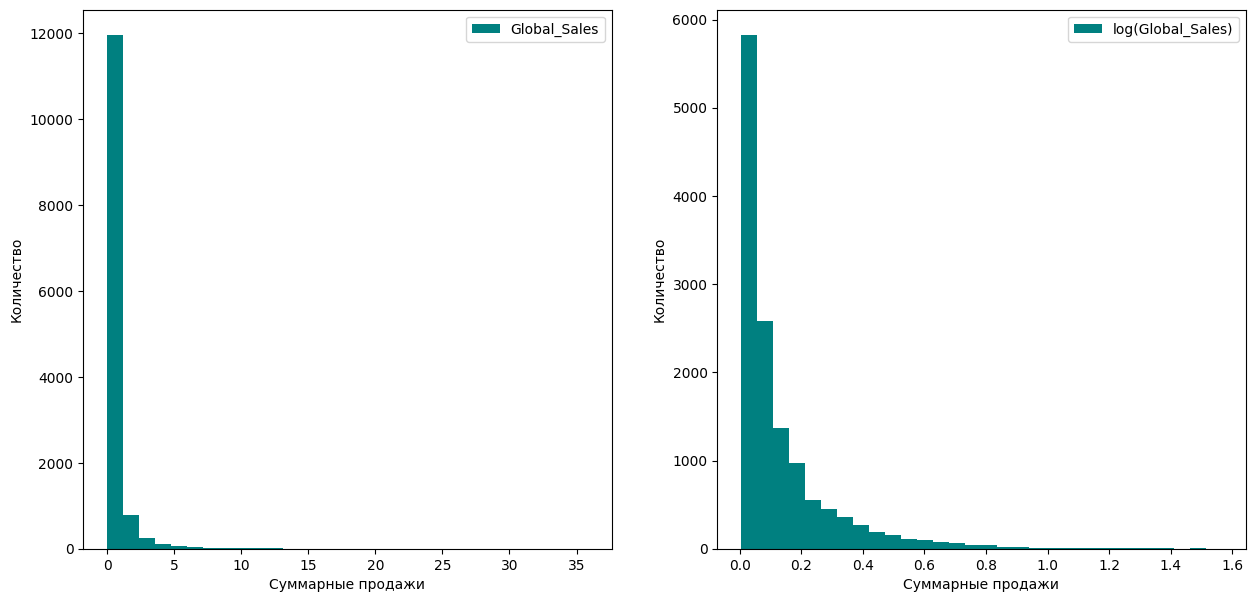

In [15]:
fign, axes = plt.subplots(nrows=1, ncols=2)
fign.set_figwidth(15)
fign.set_figheight(7)
n = 1
for axe in axes.flat:
    if n == 1:
        axe.hist(strat_train_set['Global_Sales'],
                color = 'teal', label='Global_Sales', bins = 30)
        axe.legend(loc="upper right")
        axe.set_ylabel('Количество')
        axe.set_xlabel('Суммарные продажи')
        n = n + 1
    else:
        axe.hist(np.log10(strat_train_set['Global_Sales'] + 1),
                color = 'teal', label='log(Global_Sales)', bins = 30)
        axe.legend(loc="upper right")
        axe.set_ylabel('Количество')
        axe.set_xlabel('Суммарные продажи')

In [16]:
c = strat_train_set.corr()
print(c)

                  Year  Global_Sales
Year          1.000000     -0.080534
Global_Sales -0.080534      1.000000


In [17]:
c['Global_Sales'].sort_values(ascending=False)

Global_Sales    1.000000
Year           -0.080534
Name: Global_Sales, dtype: float64

Year


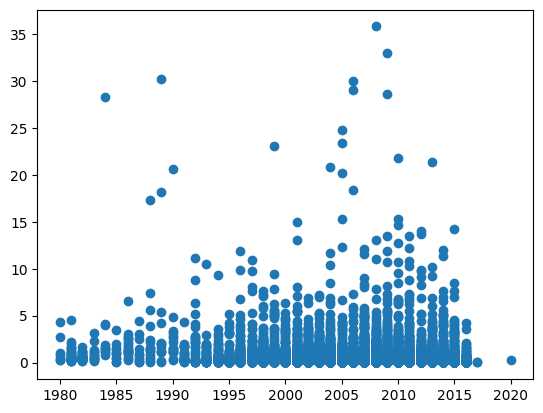

Genre


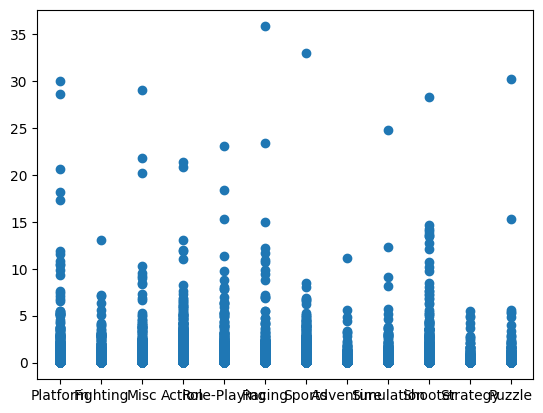

Publisher


TypeError: 'value' must be an instance of str or bytes, not a float

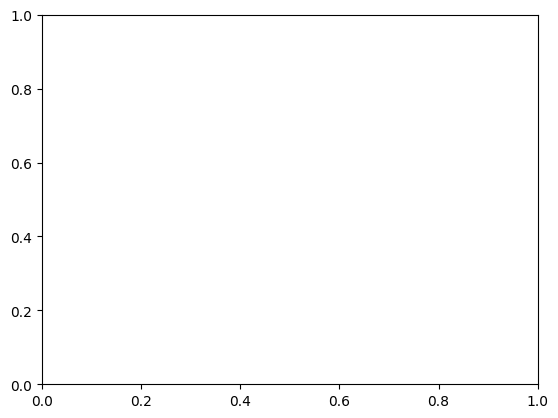

In [18]:
for name in df.columns[1:4]:
    print(name)
    plt.scatter(strat_train_set[name],strat_train_set['Global_Sales'])
    plt.show()

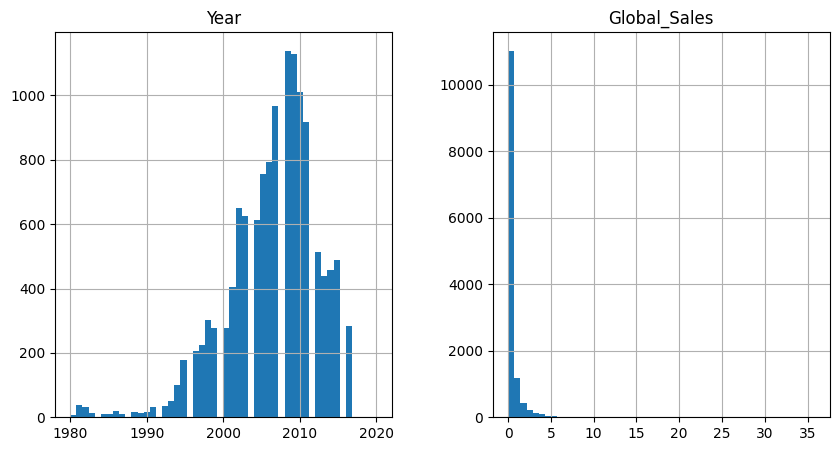

In [19]:
strat_train_set.hist(bins=50, figsize=(10,5))
plt.show()

# Работа с данными

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer
    
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer 
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
    ])

In [21]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

cat_pipeline = Pipeline([
        ('imputer',DataFrameImputer()),
        ('one-hot',OneHotEncoder(handle_unknown='ignore'))])

In [22]:
strat_train_set.columns

Index(['Platform', 'Year', 'Genre', 'Publisher', 'Global_Sales', 'cat'], dtype='object')

In [23]:
num = ['Year']
cat = list(set(df.columns) - set(num) - {'Global_Sales', 'cat'})
#cat_cols.sort()

print(num)
print(cat)

['Year']
['Platform', 'Genre', 'Publisher']


In [24]:
X_tr = strat_train_set.drop(['cat', 'Global_Sales'], axis=1)
y_tr = strat_train_set['Global_Sales'].copy()

X_test = strat_test_set.drop(['cat', 'Global_Sales'], axis=1)
y_test= strat_test_set['Global_Sales'].copy()


In [25]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num),
        ("cat", cat_pipeline, cat),
    ])

# print(X_tr)
X_res = full_pipeline.fit_transform(X_tr)
X_tres = full_pipeline.transform(X_test)
# print(X_res.shape)

In [26]:
# print(full_pipeline.named_transformers_['cat'])
print(full_pipeline.transformers_[0][1].get_feature_names_out())
print(full_pipeline.transformers_[1][1][1].get_feature_names_out())

['Year']
['Platform_2600' 'Platform_3DO' 'Platform_3DS' 'Platform_DC' 'Platform_DS'
 'Platform_GB' 'Platform_GBA' 'Platform_GC' 'Platform_GEN' 'Platform_GG'
 'Platform_N64' 'Platform_NES' 'Platform_NG' 'Platform_PC' 'Platform_PCFX'
 'Platform_PS' 'Platform_PS2' 'Platform_PS3' 'Platform_PS4' 'Platform_PSP'
 'Platform_PSV' 'Platform_SAT' 'Platform_SCD' 'Platform_SNES'
 'Platform_TG16' 'Platform_WS' 'Platform_Wii' 'Platform_WiiU'
 'Platform_X360' 'Platform_XB' 'Platform_XOne' 'Genre_Action'
 'Genre_Adventure' 'Genre_Fighting' 'Genre_Misc' 'Genre_Platform'
 'Genre_Puzzle' 'Genre_Racing' 'Genre_Role-Playing' 'Genre_Shooter'
 'Genre_Simulation' 'Genre_Sports' 'Genre_Strategy'
 'Publisher_10TACLE Studios' 'Publisher_1C Company'
 'Publisher_20th Century Fox Video Games' 'Publisher_2D Boy'
 'Publisher_3DO' 'Publisher_49Games' 'Publisher_505 Games' 'Publisher_5pb'
 'Publisher_7G//AMES' 'Publisher_989 Studios' 'Publisher_AQ Interactive'
 'Publisher_ASC Games' 'Publisher_ASCII Entertainment'
 'Pub

# LinearRegression

In [27]:
linear_grid = { 
    'copy_X':        [True, False],
    'fit_intercept': [True, False],
    'normalize' :    [True, False],
    'positive':      [True, False]
}
linear_regression = GridSearchCV(estimator=LinearRegression(), param_grid=linear_grid, cv=3, verbose=3)
# linear_regression = LinearRegression()
linear_regression.fit(X_res, y_tr)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END copy_X=True, fit_intercept=True, normalize=True, positive=True;, score=nan total time=   0.0s
[CV 2/3] END copy_X=True, fit_intercept=True, normalize=True, positive=True;, score=nan total time=   0.0s
[CV 3/3] END copy_X=True, fit_intercept=True, normalize=True, positive=True;, score=nan total time=   0.0s
[CV 1/3] END copy_X=True, fit_intercept=True, normalize=True, positive=False;, score=0.150 total time=   0.0s
[CV 2/3] END copy_X=True, fit_intercept=True, normalize=True, positive=False;, score=0.147 total time=   0.0s
[CV 3/3] END copy_X=True, fit_intercept=True, normalize=True, positive=False;, score=0.133 total time=   0.0s
[CV 1/3] END copy_X=True, fit_intercept=True, normalize=False, positive=True;, score=nan total time=   0.0s
[CV 2/3] END copy_X=True, fit_intercept=True, normalize=False, positive=True;, score=nan total time=   0.0s
[CV 3/3] END copy_X=True, fit_intercept=True, normalize=False, positive=

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]},
             verbose=3)

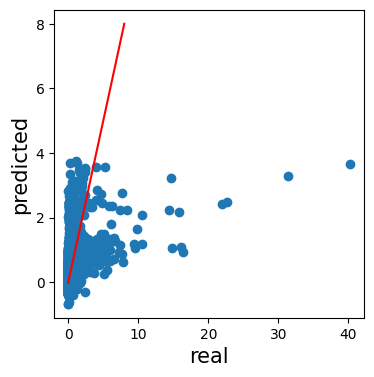

In [28]:
y_predict_lr = linear_regression.best_estimator_.predict(X_tres)

plt.figure(figsize=(4, 4))
plt.scatter(y_test.values, y_predict_lr)
plt.plot([0, 8], [0, 8], 'r')
plt.xlabel('real', fontsize=15)
plt.ylabel('predicted', fontsize=15)
plt.show()

In [29]:
lr_mse = mean_squared_error(y_test, y_predict_lr)
lr_mae = mean_absolute_error(y_test, y_predict_lr)
lr_r2_score = r2_score(y_test, y_predict_lr)

print('mse = {:.5f}'.format(lr_mse))
print('mae = {:.5f}'.format(lr_mae))
print('r2 = {:.5f}'.format(lr_r2_score))

mse = 1.95587
mae = 0.53260
r2 = 0.13632


# RandomForest

In [30]:
rfc=RandomForestRegressor(random_state=71)
forest_grid = { # Оптимальные параметры, высчитанные через нижний GridSearch
    'max_depth' : [50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2],
    'min_samples_split': [15],
    'n_estimators': [200]
}
# forest_grid = { 
#     'n_estimators':      np.linspace(start = 200, stop = 700, num = 5, dtype=int),
#     'max_features':      ['log2', 'sqrt'],
#     'max_depth' :        np.linspace(start = 20, stop = 50, num = 4, dtype=int),
#     'min_samples_split': np.linspace(start = 5, stop = 15, num = 3, dtype=int),
#     'min_samples_leaf':  np.linspace(start = 2, stop = 10, num = 3, dtype=int),
#     'bootstrap':         [True, False]
# }
clf_tree = GridSearchCV(estimator=rfc, param_grid=forest_grid, cv = 3, verbose = 3)
clf_tree.fit(X_res, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200;, score=0.162 total time=   3.3s
[CV 2/3] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200;, score=0.153 total time=   3.4s
[CV 3/3] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200;, score=0.122 total time=   3.4s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=71),
             param_grid={'max_depth': [50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2], 'min_samples_split': [15],
                         'n_estimators': [200]},
             verbose=3)

In [31]:
print(clf_tree.best_estimator_)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=15, n_estimators=200, random_state=71)


In [32]:
clf_tree.best_estimator_.fit(X_res,y_tr)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=15, n_estimators=200, random_state=71)

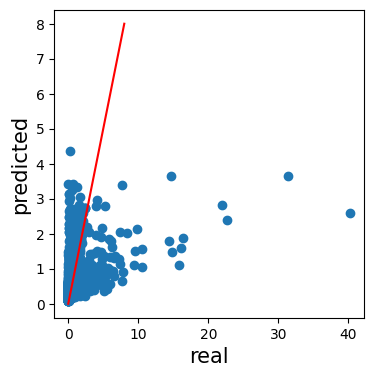

In [33]:
y_predict_rf = clf_tree.best_estimator_.predict(X_tres)

plt.figure(figsize=(4, 4))
plt.scatter(y_test.values, y_predict_rf)
plt.plot([0, 8], [0, 8], 'r')
plt.xlabel('real', fontsize=15)
plt.ylabel('predicted', fontsize=15)
plt.show()

In [34]:
rf_mse = mean_squared_error(y_test, y_predict_rf)
rf_mae = mean_absolute_error(y_test, y_predict_rf)
rf_r2_score = r2_score(y_test, y_predict_rf)

print('mse = {:.5f}'.format(rf_mse))
print('mae = {:.5f}'.format(rf_mae))
print('r2 = {:.5f}'.format(rf_r2_score))

mse = 1.91455
mae = 0.49954
r2 = 0.15457


# XGBRegressor

In [36]:
clf_xg = XGBRegressor(random_state = 71)
xgb_grid = { # Оптимальные параметры, высчитанные через нижний GridSearch
    'n_estimators': [100],
    'max_depth' : [5],
    'gamma': [100],
    'reg_alpha':[0.9],
    'min_child_weight': [4]
}
# xgb_grid = { 
#     'n_estimators':     np.linspace(start = 100, stop = 1500, num = 5, dtype=int),
#     'max_depth' :       np.linspace(start = 2, stop = 15, num = 5, dtype=int),
#     'gamma':            np.linspace(start = 100, stop = 500, num = 5, dtype=int),
#     'reg_alpha':        [0.9],
#     'min_child_weight': np.linspace(start = 1, stop = 4, num = 4, dtype=int),
# }
clf_xgb = GridSearchCV(estimator=clf_xg, param_grid=xgb_grid, cv = 3, verbose = 3)
clf_xgb.fit(X_res, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=100, max_depth=5, min_child_weight=4, n_estimators=100, reg_alpha=0.9;, score=0.098 total time=   0.1s
[CV 2/3] END gamma=100, max_depth=5, min_child_weight=4, n_estimators=100, reg_alpha=0.9;, score=0.106 total time=   0.0s
[CV 3/3] END gamma=100, max_depth=5, min_child_weight=4, n_estimators=100, reg_alpha=0.9;, score=0.058 total time=   0.0s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=71, ...),
             param_grid={'gamma': [100], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [100],
                         'reg_alpha': [0.9]},
             verbose=3)

In [37]:
print(clf_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=100, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=71, ...)


In [38]:
clf_xgb.best_estimator_.fit(X_res,y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=100, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=71, ...)

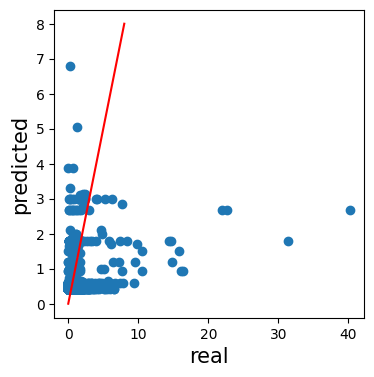

In [39]:
y_predict_xgb = clf_xgb.best_estimator_.predict(X_tres)

plt.figure(figsize=(4, 4))
plt.scatter(y_test.values, y_predict_xgb)
plt.plot([0, 8], [0, 8], 'r')
plt.xlabel('real', fontsize=15)
plt.ylabel('predicted', fontsize=15)
plt.show()

In [40]:
xgb_mse = mean_squared_error(y_test, y_predict_xgb)
xgb_mae = mean_absolute_error(y_test, y_predict_xgb)
xgb_r2_score = r2_score(y_test, y_predict_xgb)

print('mse = {:.5f}'.format(xgb_mse))
print('mae = {:.5f}'.format(xgb_mae))
print('r2 = {:.5f}'.format(xgb_r2_score))

mse = 2.06013
mae = 0.54572
r2 = 0.09028


# CatBoost

In [43]:
# X_tr = X_tr.fillna(X_tr.median())
# X_test = X_test.fillna(X_tr.median())
# print(X_tr)
# print(X_test)
# check_nans(X_test)
for item in cat:
    X_tr[item] = X_tr[item].astype("category").cat.codes
    X_test[item] = X_test[item].astype("category").cat.codes 
print(X_tr)
print(X_test)

       Platform    Year  Genre  Publisher
9202         15  2001.0      4        484
12053        26  2010.0      2        409
1828         16  2009.0      3         19
15943        19  2013.0      0        106
14395        13  2007.0      0        447
...         ...     ...    ...        ...
5826         17  2014.0      0        322
6232          4  2006.0      5        409
7921         13  2010.0      7        242
13428        13  2009.0     11        249
16452        30  2015.0      0        473

[13277 rows x 4 columns]
       Platform    Year  Genre  Publisher
10426         4  2010.0      3          4
4291         23  2006.0     10         81
1787         14  2005.0      9        158
15364         4  2010.0      1         23
466          14  2002.0     10        269
...         ...     ...    ...        ...
1652         24  2001.0      3        182
3096         14  2008.0      0         16
1180         14  2009.0     10        158
7940         18  2015.0      0        193
9331    

In [44]:
cat_grid = [{
    'n_estimators':   np.arange(start = 100, stop = 500, step = 100, dtype=int),
    'max_depth':      np.arange(start = 3, stop = 5, step = 1, dtype=int),
    'learning_rate':  np.arange(start = 0.1, stop = 0.3, step = 0.1)
}]
cat_features_index = [0,2,3]
cat_regressor = GridSearchCV(estimator=CatBoostRegressor(random_state = 71), param_grid=cat_grid, cv = 3, verbose = 3)
cat_regressor.fit(X_tr, y_tr)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
0:	learn: 1.4407158	total: 191ms	remaining: 18.9s
1:	learn: 1.4378025	total: 193ms	remaining: 9.45s
2:	learn: 1.4275775	total: 195ms	remaining: 6.29s
3:	learn: 1.4194149	total: 196ms	remaining: 4.7s
4:	learn: 1.4116771	total: 198ms	remaining: 3.75s
5:	learn: 1.4096405	total: 199ms	remaining: 3.12s
6:	learn: 1.4039378	total: 201ms	remaining: 2.67s
7:	learn: 1.4011474	total: 202ms	remaining: 2.33s
8:	learn: 1.3998580	total: 204ms	remaining: 2.06s
9:	learn: 1.3954004	total: 205ms	remaining: 1.85s
10:	learn: 1.3913138	total: 207ms	remaining: 1.67s
11:	learn: 1.3901818	total: 208ms	remaining: 1.52s
12:	learn: 1.3882001	total: 209ms	remaining: 1.4s
13:	learn: 1.3876963	total: 211ms	remaining: 1.29s
14:	learn: 1.3867085	total: 212ms	remaining: 1.2s
15:	learn: 1.3857331	total: 213ms	remaining: 1.12s
16:	learn: 1.3850962	total: 215ms	remaining: 1.05s
17:	learn: 1.3836397	total: 216ms	remaining: 984ms
18:	learn: 1.3833025	total: 217ms	

52:	learn: 1.2346643	total: 74.5ms	remaining: 66ms
53:	learn: 1.2345335	total: 76.2ms	remaining: 64.9ms
54:	learn: 1.2343025	total: 78.2ms	remaining: 64ms
55:	learn: 1.2339491	total: 80.1ms	remaining: 62.9ms
56:	learn: 1.2337326	total: 81.9ms	remaining: 61.8ms
57:	learn: 1.2328673	total: 83.8ms	remaining: 60.7ms
58:	learn: 1.2317979	total: 85.6ms	remaining: 59.5ms
59:	learn: 1.2311944	total: 87.4ms	remaining: 58.3ms
60:	learn: 1.2309224	total: 89.2ms	remaining: 57ms
61:	learn: 1.2301063	total: 91ms	remaining: 55.8ms
62:	learn: 1.2300212	total: 92.8ms	remaining: 54.5ms
63:	learn: 1.2288546	total: 94.9ms	remaining: 53.4ms
64:	learn: 1.2286976	total: 96.6ms	remaining: 52ms
65:	learn: 1.2277288	total: 98.3ms	remaining: 50.6ms
66:	learn: 1.2272646	total: 100ms	remaining: 49.3ms
67:	learn: 1.2265733	total: 102ms	remaining: 48.2ms
68:	learn: 1.2261744	total: 104ms	remaining: 46.9ms
69:	learn: 1.2258641	total: 106ms	remaining: 45.6ms
70:	learn: 1.2256264	total: 109ms	remaining: 44.3ms
71:	lear

13:	learn: 1.3728169	total: 18.9ms	remaining: 252ms
14:	learn: 1.3718481	total: 20.5ms	remaining: 253ms
15:	learn: 1.3708791	total: 22.3ms	remaining: 256ms
16:	learn: 1.3702124	total: 23.5ms	remaining: 253ms
17:	learn: 1.3658523	total: 24.6ms	remaining: 249ms
18:	learn: 1.3647991	total: 25.7ms	remaining: 245ms
19:	learn: 1.3640855	total: 27ms	remaining: 243ms
20:	learn: 1.3635890	total: 28.3ms	remaining: 241ms
21:	learn: 1.3600331	total: 29.5ms	remaining: 239ms
22:	learn: 1.3595128	total: 30.8ms	remaining: 237ms
23:	learn: 1.3590278	total: 32ms	remaining: 235ms
24:	learn: 1.3581967	total: 33.5ms	remaining: 234ms
25:	learn: 1.3578499	total: 35ms	remaining: 234ms
26:	learn: 1.3570365	total: 36.6ms	remaining: 235ms
27:	learn: 1.3565740	total: 38.1ms	remaining: 234ms
28:	learn: 1.3563396	total: 39.5ms	remaining: 233ms
29:	learn: 1.3537511	total: 40.9ms	remaining: 232ms
30:	learn: 1.3527710	total: 42.1ms	remaining: 229ms
31:	learn: 1.3523168	total: 43.2ms	remaining: 227ms
32:	learn: 1.35169

87:	learn: 1.2198950	total: 117ms	remaining: 149ms
88:	learn: 1.2196848	total: 118ms	remaining: 148ms
89:	learn: 1.2191547	total: 120ms	remaining: 146ms
90:	learn: 1.2186193	total: 121ms	remaining: 145ms
91:	learn: 1.2182442	total: 122ms	remaining: 144ms
92:	learn: 1.2178176	total: 124ms	remaining: 142ms
93:	learn: 1.2175994	total: 125ms	remaining: 141ms
94:	learn: 1.2174769	total: 126ms	remaining: 140ms
95:	learn: 1.2169428	total: 128ms	remaining: 138ms
96:	learn: 1.2166571	total: 129ms	remaining: 137ms
97:	learn: 1.2160095	total: 130ms	remaining: 136ms
98:	learn: 1.2156191	total: 132ms	remaining: 134ms
99:	learn: 1.2153974	total: 133ms	remaining: 133ms
100:	learn: 1.2148693	total: 135ms	remaining: 132ms
101:	learn: 1.2145006	total: 136ms	remaining: 131ms
102:	learn: 1.2142919	total: 138ms	remaining: 130ms
103:	learn: 1.2137051	total: 139ms	remaining: 128ms
104:	learn: 1.2135055	total: 140ms	remaining: 127ms
105:	learn: 1.2132791	total: 142ms	remaining: 126ms
106:	learn: 1.2130250	tot

150:	learn: 1.3235117	total: 197ms	remaining: 194ms
151:	learn: 1.3232413	total: 199ms	remaining: 193ms
152:	learn: 1.3220708	total: 200ms	remaining: 192ms
153:	learn: 1.3218867	total: 201ms	remaining: 191ms
154:	learn: 1.3217424	total: 202ms	remaining: 189ms
155:	learn: 1.3215056	total: 204ms	remaining: 188ms
156:	learn: 1.3213106	total: 205ms	remaining: 187ms
157:	learn: 1.3210037	total: 207ms	remaining: 186ms
158:	learn: 1.3205725	total: 208ms	remaining: 184ms
159:	learn: 1.3202553	total: 209ms	remaining: 183ms
160:	learn: 1.3199033	total: 211ms	remaining: 182ms
161:	learn: 1.3191479	total: 212ms	remaining: 181ms
162:	learn: 1.3188560	total: 213ms	remaining: 179ms
163:	learn: 1.3186579	total: 215ms	remaining: 178ms
164:	learn: 1.3184195	total: 216ms	remaining: 177ms
165:	learn: 1.3182649	total: 218ms	remaining: 176ms
166:	learn: 1.3180720	total: 219ms	remaining: 174ms
167:	learn: 1.3174489	total: 220ms	remaining: 173ms
168:	learn: 1.3172842	total: 222ms	remaining: 172ms
169:	learn: 

131:	learn: 1.3115952	total: 165ms	remaining: 210ms
132:	learn: 1.3114116	total: 166ms	remaining: 209ms
133:	learn: 1.3112456	total: 168ms	remaining: 208ms
134:	learn: 1.3109472	total: 169ms	remaining: 207ms
135:	learn: 1.3105152	total: 170ms	remaining: 206ms
136:	learn: 1.3103161	total: 172ms	remaining: 205ms
137:	learn: 1.3100897	total: 173ms	remaining: 204ms
138:	learn: 1.3099519	total: 175ms	remaining: 203ms
139:	learn: 1.3097911	total: 176ms	remaining: 202ms
140:	learn: 1.3094025	total: 178ms	remaining: 201ms
141:	learn: 1.3091900	total: 180ms	remaining: 200ms
142:	learn: 1.3090100	total: 181ms	remaining: 199ms
143:	learn: 1.3087454	total: 182ms	remaining: 197ms
144:	learn: 1.3085507	total: 184ms	remaining: 196ms
145:	learn: 1.3083621	total: 185ms	remaining: 195ms
146:	learn: 1.3081197	total: 186ms	remaining: 194ms
147:	learn: 1.3078156	total: 188ms	remaining: 193ms
148:	learn: 1.3077129	total: 189ms	remaining: 191ms
149:	learn: 1.3076424	total: 191ms	remaining: 191ms
150:	learn: 

96:	learn: 1.2166571	total: 119ms	remaining: 250ms
97:	learn: 1.2160095	total: 121ms	remaining: 249ms
98:	learn: 1.2156191	total: 122ms	remaining: 248ms
99:	learn: 1.2153974	total: 123ms	remaining: 247ms
100:	learn: 1.2148693	total: 125ms	remaining: 246ms
101:	learn: 1.2145006	total: 126ms	remaining: 245ms
102:	learn: 1.2142919	total: 128ms	remaining: 244ms
103:	learn: 1.2137051	total: 129ms	remaining: 243ms
104:	learn: 1.2135055	total: 130ms	remaining: 242ms
105:	learn: 1.2132791	total: 131ms	remaining: 241ms
106:	learn: 1.2130250	total: 133ms	remaining: 239ms
107:	learn: 1.2125588	total: 134ms	remaining: 238ms
108:	learn: 1.2120990	total: 135ms	remaining: 237ms
109:	learn: 1.2116689	total: 136ms	remaining: 236ms
110:	learn: 1.2112136	total: 138ms	remaining: 234ms
111:	learn: 1.2103857	total: 139ms	remaining: 233ms
112:	learn: 1.2099610	total: 140ms	remaining: 232ms
113:	learn: 1.2095815	total: 141ms	remaining: 231ms
114:	learn: 1.2094070	total: 142ms	remaining: 229ms
115:	learn: 1.20

70:	learn: 1.3507720	total: 92ms	remaining: 426ms
71:	learn: 1.3505860	total: 93.2ms	remaining: 425ms
72:	learn: 1.3502658	total: 94.5ms	remaining: 423ms
73:	learn: 1.3497014	total: 95.7ms	remaining: 422ms
74:	learn: 1.3495114	total: 96.9ms	remaining: 420ms
75:	learn: 1.3491840	total: 98ms	remaining: 418ms
76:	learn: 1.3489109	total: 99.3ms	remaining: 416ms
77:	learn: 1.3485726	total: 100ms	remaining: 415ms
78:	learn: 1.3472280	total: 102ms	remaining: 413ms
79:	learn: 1.3469888	total: 103ms	remaining: 412ms
80:	learn: 1.3466380	total: 104ms	remaining: 410ms
81:	learn: 1.3464744	total: 105ms	remaining: 408ms
82:	learn: 1.3462585	total: 107ms	remaining: 407ms
83:	learn: 1.3461603	total: 108ms	remaining: 405ms
84:	learn: 1.3459429	total: 109ms	remaining: 403ms
85:	learn: 1.3456686	total: 110ms	remaining: 402ms
86:	learn: 1.3448544	total: 111ms	remaining: 401ms
87:	learn: 1.3440638	total: 113ms	remaining: 399ms
88:	learn: 1.3430766	total: 114ms	remaining: 398ms
89:	learn: 1.3424738	total: 

230:	learn: 1.3048792	total: 290ms	remaining: 212ms
231:	learn: 1.3047943	total: 291ms	remaining: 211ms
232:	learn: 1.3047045	total: 292ms	remaining: 209ms
233:	learn: 1.3045299	total: 294ms	remaining: 208ms
234:	learn: 1.3042697	total: 295ms	remaining: 207ms
235:	learn: 1.3041910	total: 296ms	remaining: 206ms
236:	learn: 1.3041156	total: 298ms	remaining: 205ms
237:	learn: 1.3039871	total: 299ms	remaining: 204ms
238:	learn: 1.3038585	total: 300ms	remaining: 202ms
239:	learn: 1.3032143	total: 301ms	remaining: 201ms
240:	learn: 1.3031550	total: 303ms	remaining: 200ms
241:	learn: 1.3029409	total: 304ms	remaining: 198ms
242:	learn: 1.3023866	total: 305ms	remaining: 197ms
243:	learn: 1.3021419	total: 306ms	remaining: 196ms
244:	learn: 1.3020688	total: 307ms	remaining: 194ms
245:	learn: 1.3019572	total: 309ms	remaining: 193ms
246:	learn: 1.3018569	total: 310ms	remaining: 192ms
247:	learn: 1.3017738	total: 311ms	remaining: 191ms
248:	learn: 1.3015505	total: 312ms	remaining: 189ms
249:	learn: 

390:	learn: 1.2843416	total: 481ms	remaining: 11.1ms
391:	learn: 1.2842174	total: 483ms	remaining: 9.85ms
392:	learn: 1.2840611	total: 484ms	remaining: 8.63ms
393:	learn: 1.2840139	total: 486ms	remaining: 7.39ms
394:	learn: 1.2839437	total: 487ms	remaining: 6.17ms
395:	learn: 1.2838432	total: 489ms	remaining: 4.93ms
396:	learn: 1.2838169	total: 490ms	remaining: 3.7ms
397:	learn: 1.2837515	total: 491ms	remaining: 2.47ms
398:	learn: 1.2835514	total: 493ms	remaining: 1.23ms
399:	learn: 1.2835162	total: 494ms	remaining: 0us
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=400;, score=0.158 total time=   0.5s
0:	learn: 1.4230607	total: 1.8ms	remaining: 718ms
1:	learn: 1.4196054	total: 3.48ms	remaining: 692ms
2:	learn: 1.4082631	total: 5.22ms	remaining: 691ms
3:	learn: 1.3984650	total: 6.67ms	remaining: 661ms
4:	learn: 1.3922349	total: 8.01ms	remaining: 633ms
5:	learn: 1.3912366	total: 9.19ms	remaining: 604ms
6:	learn: 1.3851926	total: 10.4ms	remaining: 586ms
7:	learn: 1.3828639	tot

265:	learn: 1.2880988	total: 340ms	remaining: 171ms
266:	learn: 1.2880196	total: 341ms	remaining: 170ms
267:	learn: 1.2879558	total: 342ms	remaining: 168ms
268:	learn: 1.2878378	total: 343ms	remaining: 167ms
269:	learn: 1.2877206	total: 345ms	remaining: 166ms
270:	learn: 1.2876508	total: 346ms	remaining: 165ms
271:	learn: 1.2875808	total: 348ms	remaining: 164ms
272:	learn: 1.2875193	total: 349ms	remaining: 162ms
273:	learn: 1.2874490	total: 351ms	remaining: 161ms
274:	learn: 1.2873750	total: 352ms	remaining: 160ms
275:	learn: 1.2872372	total: 353ms	remaining: 159ms
276:	learn: 1.2871677	total: 355ms	remaining: 157ms
277:	learn: 1.2871199	total: 356ms	remaining: 156ms
278:	learn: 1.2869860	total: 357ms	remaining: 155ms
279:	learn: 1.2868839	total: 359ms	remaining: 154ms
280:	learn: 1.2867930	total: 360ms	remaining: 152ms
281:	learn: 1.2866953	total: 361ms	remaining: 151ms
282:	learn: 1.2866521	total: 363ms	remaining: 150ms
283:	learn: 1.2864345	total: 364ms	remaining: 149ms
284:	learn: 

146:	learn: 1.1998241	total: 194ms	remaining: 334ms
147:	learn: 1.1996398	total: 196ms	remaining: 333ms
148:	learn: 1.1994830	total: 197ms	remaining: 332ms
149:	learn: 1.1986044	total: 199ms	remaining: 331ms
150:	learn: 1.1985021	total: 200ms	remaining: 329ms
151:	learn: 1.1983033	total: 201ms	remaining: 328ms
152:	learn: 1.1980422	total: 202ms	remaining: 327ms
153:	learn: 1.1973913	total: 204ms	remaining: 326ms
154:	learn: 1.1971094	total: 205ms	remaining: 325ms
155:	learn: 1.1968089	total: 207ms	remaining: 324ms
156:	learn: 1.1966917	total: 208ms	remaining: 323ms
157:	learn: 1.1964676	total: 210ms	remaining: 321ms
158:	learn: 1.1960961	total: 211ms	remaining: 320ms
159:	learn: 1.1958909	total: 212ms	remaining: 319ms
160:	learn: 1.1957371	total: 214ms	remaining: 317ms
161:	learn: 1.1956225	total: 215ms	remaining: 316ms
162:	learn: 1.1955382	total: 216ms	remaining: 314ms
163:	learn: 1.1953926	total: 218ms	remaining: 313ms
164:	learn: 1.1952923	total: 219ms	remaining: 312ms
165:	learn: 

23:	learn: 1.3690975	total: 35.5ms	remaining: 112ms
24:	learn: 1.3682730	total: 37.2ms	remaining: 112ms
25:	learn: 1.3661387	total: 38.8ms	remaining: 111ms
26:	learn: 1.3651340	total: 40.4ms	remaining: 109ms
27:	learn: 1.3640296	total: 41.8ms	remaining: 107ms
28:	learn: 1.3634680	total: 43.2ms	remaining: 106ms
29:	learn: 1.3628467	total: 44.7ms	remaining: 104ms
30:	learn: 1.3624984	total: 46.2ms	remaining: 103ms
31:	learn: 1.3614916	total: 47.6ms	remaining: 101ms
32:	learn: 1.3610387	total: 49ms	remaining: 99.5ms
33:	learn: 1.3584820	total: 50.5ms	remaining: 98.1ms
34:	learn: 1.3578786	total: 52ms	remaining: 96.6ms
35:	learn: 1.3575994	total: 53.4ms	remaining: 94.9ms
36:	learn: 1.3570403	total: 54.9ms	remaining: 93.5ms
37:	learn: 1.3564129	total: 56.5ms	remaining: 92.2ms
38:	learn: 1.3542561	total: 57.9ms	remaining: 90.6ms
39:	learn: 1.3536131	total: 59.3ms	remaining: 89ms
40:	learn: 1.3530296	total: 60.8ms	remaining: 87.5ms
41:	learn: 1.3527162	total: 62.1ms	remaining: 85.8ms
42:	lear

26:	learn: 1.2378322	total: 39.5ms	remaining: 107ms
27:	learn: 1.2369348	total: 41.3ms	remaining: 106ms
28:	learn: 1.2361226	total: 43ms	remaining: 105ms
29:	learn: 1.2357272	total: 44.7ms	remaining: 104ms
30:	learn: 1.2349932	total: 46.3ms	remaining: 103ms
31:	learn: 1.2340947	total: 47.8ms	remaining: 102ms
32:	learn: 1.2330310	total: 49.4ms	remaining: 100ms
33:	learn: 1.2325748	total: 50.9ms	remaining: 98.8ms
34:	learn: 1.2323030	total: 52.2ms	remaining: 97ms
35:	learn: 1.2320308	total: 53.6ms	remaining: 95.2ms
36:	learn: 1.2315838	total: 55ms	remaining: 93.7ms
37:	learn: 1.2300070	total: 56.4ms	remaining: 92ms
38:	learn: 1.2296416	total: 57.8ms	remaining: 90.4ms
39:	learn: 1.2285555	total: 59.3ms	remaining: 88.9ms
40:	learn: 1.2280696	total: 60.9ms	remaining: 87.6ms
41:	learn: 1.2275752	total: 62.3ms	remaining: 86.1ms
42:	learn: 1.2270269	total: 63.8ms	remaining: 84.6ms
43:	learn: 1.2261980	total: 65.3ms	remaining: 83.1ms
44:	learn: 1.2254836	total: 66.7ms	remaining: 81.5ms
45:	lear

182:	learn: 1.2788230	total: 261ms	remaining: 24.3ms
183:	learn: 1.2785697	total: 263ms	remaining: 22.9ms
184:	learn: 1.2780942	total: 265ms	remaining: 21.5ms
185:	learn: 1.2780035	total: 266ms	remaining: 20ms
186:	learn: 1.2776791	total: 268ms	remaining: 18.6ms
187:	learn: 1.2775092	total: 269ms	remaining: 17.2ms
188:	learn: 1.2772508	total: 271ms	remaining: 15.8ms
189:	learn: 1.2769816	total: 272ms	remaining: 14.3ms
190:	learn: 1.2766048	total: 274ms	remaining: 12.9ms
191:	learn: 1.2762757	total: 275ms	remaining: 11.5ms
192:	learn: 1.2761271	total: 277ms	remaining: 10ms
193:	learn: 1.2759630	total: 278ms	remaining: 8.6ms
194:	learn: 1.2758273	total: 280ms	remaining: 7.17ms
195:	learn: 1.2757078	total: 281ms	remaining: 5.73ms
196:	learn: 1.2752877	total: 282ms	remaining: 4.3ms
197:	learn: 1.2747683	total: 284ms	remaining: 2.87ms
198:	learn: 1.2742053	total: 285ms	remaining: 1.43ms
199:	learn: 1.2739331	total: 287ms	remaining: 0us
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimato

0:	learn: 1.3019083	total: 1.43ms	remaining: 284ms
1:	learn: 1.2926379	total: 2.89ms	remaining: 286ms
2:	learn: 1.2853752	total: 4.33ms	remaining: 285ms
3:	learn: 1.2778926	total: 5.84ms	remaining: 286ms
4:	learn: 1.2758165	total: 7.4ms	remaining: 289ms
5:	learn: 1.2731928	total: 9.03ms	remaining: 292ms
6:	learn: 1.2684155	total: 10.4ms	remaining: 287ms
7:	learn: 1.2672348	total: 11.7ms	remaining: 282ms
8:	learn: 1.2633727	total: 13.2ms	remaining: 280ms
9:	learn: 1.2597699	total: 14.6ms	remaining: 278ms
10:	learn: 1.2563990	total: 16ms	remaining: 275ms
11:	learn: 1.2555506	total: 17.4ms	remaining: 272ms
12:	learn: 1.2533400	total: 19ms	remaining: 273ms
13:	learn: 1.2524008	total: 20.5ms	remaining: 273ms
14:	learn: 1.2516494	total: 22.1ms	remaining: 273ms
15:	learn: 1.2502139	total: 23.6ms	remaining: 272ms
16:	learn: 1.2495793	total: 25.1ms	remaining: 270ms
17:	learn: 1.2482504	total: 26.6ms	remaining: 269ms
18:	learn: 1.2469557	total: 28ms	remaining: 267ms
19:	learn: 1.2452721	total: 2

35:	learn: 1.3575994	total: 55.8ms	remaining: 409ms
36:	learn: 1.3570403	total: 57.5ms	remaining: 409ms
37:	learn: 1.3564129	total: 59.2ms	remaining: 408ms
38:	learn: 1.3542561	total: 61ms	remaining: 408ms
39:	learn: 1.3536131	total: 62.8ms	remaining: 408ms
40:	learn: 1.3530296	total: 64.7ms	remaining: 409ms
41:	learn: 1.3527162	total: 66.5ms	remaining: 409ms
42:	learn: 1.3520104	total: 67.9ms	remaining: 406ms
43:	learn: 1.3513445	total: 69.3ms	remaining: 403ms
44:	learn: 1.3509627	total: 70.7ms	remaining: 401ms
45:	learn: 1.3506173	total: 72.1ms	remaining: 398ms
46:	learn: 1.3496652	total: 73.5ms	remaining: 396ms
47:	learn: 1.3481632	total: 75ms	remaining: 394ms
48:	learn: 1.3474973	total: 76.4ms	remaining: 391ms
49:	learn: 1.3472178	total: 77.9ms	remaining: 390ms
50:	learn: 1.3468360	total: 79.6ms	remaining: 389ms
51:	learn: 1.3462847	total: 81ms	remaining: 386ms
52:	learn: 1.3456778	total: 82.5ms	remaining: 384ms
53:	learn: 1.3450899	total: 83.9ms	remaining: 382ms
54:	learn: 1.34410

[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.165 total time=   0.4s
0:	learn: 1.4212119	total: 1.42ms	remaining: 425ms
1:	learn: 1.4081381	total: 2.87ms	remaining: 428ms
2:	learn: 1.3983149	total: 4.34ms	remaining: 429ms
3:	learn: 1.3910093	total: 5.84ms	remaining: 433ms
4:	learn: 1.3884695	total: 7.21ms	remaining: 426ms
5:	learn: 1.3819700	total: 8.64ms	remaining: 424ms
6:	learn: 1.3757190	total: 10.1ms	remaining: 422ms
7:	learn: 1.3737264	total: 11.6ms	remaining: 424ms
8:	learn: 1.3688728	total: 13.3ms	remaining: 431ms
9:	learn: 1.3650834	total: 14.8ms	remaining: 430ms
10:	learn: 1.3615687	total: 16.4ms	remaining: 431ms
11:	learn: 1.3607405	total: 17.8ms	remaining: 428ms
12:	learn: 1.3593381	total: 19.2ms	remaining: 425ms
13:	learn: 1.3582646	total: 20.6ms	remaining: 421ms
14:	learn: 1.3571956	total: 22.1ms	remaining: 419ms
15:	learn: 1.3564174	total: 23.5ms	remaining: 417ms
16:	learn: 1.3556975	total: 25.1ms	remaining: 418ms
17:	learn: 1.3546667	total: 26.

254:	learn: 1.2581046	total: 373ms	remaining: 65.8ms
255:	learn: 1.2579419	total: 374ms	remaining: 64.4ms
256:	learn: 1.2578095	total: 376ms	remaining: 62.9ms
257:	learn: 1.2575921	total: 378ms	remaining: 61.5ms
258:	learn: 1.2574494	total: 379ms	remaining: 60ms
259:	learn: 1.2573954	total: 381ms	remaining: 58.6ms
260:	learn: 1.2572753	total: 382ms	remaining: 57.1ms
261:	learn: 1.2571275	total: 384ms	remaining: 55.7ms
262:	learn: 1.2570144	total: 385ms	remaining: 54.2ms
263:	learn: 1.2569387	total: 387ms	remaining: 52.7ms
264:	learn: 1.2568577	total: 388ms	remaining: 51.3ms
265:	learn: 1.2567098	total: 390ms	remaining: 49.8ms
266:	learn: 1.2564299	total: 391ms	remaining: 48.4ms
267:	learn: 1.2562788	total: 393ms	remaining: 46.9ms
268:	learn: 1.2560300	total: 394ms	remaining: 45.4ms
269:	learn: 1.2558517	total: 395ms	remaining: 43.9ms
270:	learn: 1.2557177	total: 397ms	remaining: 42.5ms
271:	learn: 1.2556524	total: 398ms	remaining: 41ms
272:	learn: 1.2555055	total: 400ms	remaining: 39.5

193:	learn: 1.1561588	total: 285ms	remaining: 156ms
194:	learn: 1.1559981	total: 286ms	remaining: 154ms
195:	learn: 1.1558678	total: 288ms	remaining: 153ms
196:	learn: 1.1557132	total: 290ms	remaining: 151ms
197:	learn: 1.1556062	total: 291ms	remaining: 150ms
198:	learn: 1.1551915	total: 293ms	remaining: 149ms
199:	learn: 1.1543001	total: 295ms	remaining: 147ms
200:	learn: 1.1541909	total: 296ms	remaining: 146ms
201:	learn: 1.1534508	total: 297ms	remaining: 144ms
202:	learn: 1.1532864	total: 299ms	remaining: 143ms
203:	learn: 1.1530319	total: 300ms	remaining: 141ms
204:	learn: 1.1525226	total: 302ms	remaining: 140ms
205:	learn: 1.1520868	total: 303ms	remaining: 138ms
206:	learn: 1.1519521	total: 305ms	remaining: 137ms
207:	learn: 1.1518088	total: 306ms	remaining: 136ms
208:	learn: 1.1517210	total: 308ms	remaining: 134ms
209:	learn: 1.1515623	total: 309ms	remaining: 133ms
210:	learn: 1.1511093	total: 311ms	remaining: 131ms
211:	learn: 1.1509512	total: 312ms	remaining: 130ms
212:	learn: 

141:	learn: 1.2948100	total: 208ms	remaining: 377ms
142:	learn: 1.2939084	total: 209ms	remaining: 376ms
143:	learn: 1.2932597	total: 211ms	remaining: 375ms
144:	learn: 1.2928414	total: 213ms	remaining: 374ms
145:	learn: 1.2923393	total: 214ms	remaining: 372ms
146:	learn: 1.2919066	total: 215ms	remaining: 371ms
147:	learn: 1.2916367	total: 217ms	remaining: 369ms
148:	learn: 1.2913925	total: 218ms	remaining: 368ms
149:	learn: 1.2909314	total: 220ms	remaining: 366ms
150:	learn: 1.2907339	total: 221ms	remaining: 365ms
151:	learn: 1.2896733	total: 223ms	remaining: 364ms
152:	learn: 1.2894683	total: 224ms	remaining: 362ms
153:	learn: 1.2885832	total: 226ms	remaining: 361ms
154:	learn: 1.2881538	total: 227ms	remaining: 360ms
155:	learn: 1.2878116	total: 229ms	remaining: 358ms
156:	learn: 1.2876099	total: 231ms	remaining: 357ms
157:	learn: 1.2871898	total: 232ms	remaining: 356ms
158:	learn: 1.2871086	total: 234ms	remaining: 354ms
159:	learn: 1.2868578	total: 235ms	remaining: 352ms
160:	learn: 

[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=400;, score=0.163 total time=   0.6s
0:	learn: 1.4212119	total: 1.46ms	remaining: 583ms
1:	learn: 1.4081381	total: 3.07ms	remaining: 611ms
2:	learn: 1.3983149	total: 4.5ms	remaining: 596ms
3:	learn: 1.3910093	total: 6.01ms	remaining: 595ms
4:	learn: 1.3884695	total: 7.46ms	remaining: 589ms
5:	learn: 1.3819700	total: 8.83ms	remaining: 580ms
6:	learn: 1.3757190	total: 10.3ms	remaining: 578ms
7:	learn: 1.3737264	total: 11.8ms	remaining: 579ms
8:	learn: 1.3688728	total: 13.2ms	remaining: 573ms
9:	learn: 1.3650834	total: 14.6ms	remaining: 568ms
10:	learn: 1.3615687	total: 15.9ms	remaining: 564ms
11:	learn: 1.3607405	total: 17.3ms	remaining: 560ms
12:	learn: 1.3593381	total: 18.7ms	remaining: 557ms
13:	learn: 1.3582646	total: 20.1ms	remaining: 555ms
14:	learn: 1.3571956	total: 21.7ms	remaining: 558ms
15:	learn: 1.3564174	total: 23.2ms	remaining: 556ms
16:	learn: 1.3556975	total: 24.6ms	remaining: 555ms
17:	learn: 1.3546667	total: 26.1

243:	learn: 1.2603305	total: 363ms	remaining: 232ms
244:	learn: 1.2601607	total: 365ms	remaining: 231ms
245:	learn: 1.2599443	total: 367ms	remaining: 230ms
246:	learn: 1.2598087	total: 368ms	remaining: 228ms
247:	learn: 1.2594779	total: 370ms	remaining: 227ms
248:	learn: 1.2593404	total: 371ms	remaining: 225ms
249:	learn: 1.2591320	total: 373ms	remaining: 224ms
250:	learn: 1.2588976	total: 374ms	remaining: 222ms
251:	learn: 1.2588041	total: 376ms	remaining: 221ms
252:	learn: 1.2587697	total: 377ms	remaining: 219ms
253:	learn: 1.2586250	total: 379ms	remaining: 218ms
254:	learn: 1.2581046	total: 380ms	remaining: 216ms
255:	learn: 1.2579419	total: 382ms	remaining: 215ms
256:	learn: 1.2578095	total: 383ms	remaining: 213ms
257:	learn: 1.2575921	total: 385ms	remaining: 212ms
258:	learn: 1.2574494	total: 386ms	remaining: 210ms
259:	learn: 1.2573954	total: 388ms	remaining: 209ms
260:	learn: 1.2572753	total: 389ms	remaining: 207ms
261:	learn: 1.2571275	total: 391ms	remaining: 206ms
262:	learn: 

85:	learn: 1.2018610	total: 124ms	remaining: 454ms
86:	learn: 1.2014062	total: 126ms	remaining: 452ms
87:	learn: 1.2009542	total: 127ms	remaining: 452ms
88:	learn: 1.2006365	total: 129ms	remaining: 451ms
89:	learn: 1.1992842	total: 131ms	remaining: 450ms
90:	learn: 1.1984103	total: 132ms	remaining: 449ms
91:	learn: 1.1978829	total: 134ms	remaining: 448ms
92:	learn: 1.1976063	total: 135ms	remaining: 447ms
93:	learn: 1.1966242	total: 137ms	remaining: 445ms
94:	learn: 1.1963738	total: 138ms	remaining: 443ms
95:	learn: 1.1958476	total: 140ms	remaining: 443ms
96:	learn: 1.1945264	total: 141ms	remaining: 441ms
97:	learn: 1.1936968	total: 143ms	remaining: 440ms
98:	learn: 1.1932045	total: 144ms	remaining: 438ms
99:	learn: 1.1924546	total: 146ms	remaining: 437ms
100:	learn: 1.1921309	total: 147ms	remaining: 435ms
101:	learn: 1.1915691	total: 148ms	remaining: 433ms
102:	learn: 1.1914259	total: 150ms	remaining: 432ms
103:	learn: 1.1909451	total: 151ms	remaining: 431ms
104:	learn: 1.1905117	total

343:	learn: 1.1237787	total: 511ms	remaining: 83.1ms
344:	learn: 1.1235363	total: 513ms	remaining: 81.7ms
345:	learn: 1.1233955	total: 514ms	remaining: 80.3ms
346:	learn: 1.1232191	total: 516ms	remaining: 78.8ms
347:	learn: 1.1231429	total: 518ms	remaining: 77.3ms
348:	learn: 1.1229905	total: 519ms	remaining: 75.8ms
349:	learn: 1.1228878	total: 521ms	remaining: 74.4ms
350:	learn: 1.1226178	total: 522ms	remaining: 72.9ms
351:	learn: 1.1224897	total: 524ms	remaining: 71.4ms
352:	learn: 1.1223624	total: 525ms	remaining: 69.9ms
353:	learn: 1.1223137	total: 527ms	remaining: 68.5ms
354:	learn: 1.1218944	total: 529ms	remaining: 67ms
355:	learn: 1.1218342	total: 530ms	remaining: 65.5ms
356:	learn: 1.1217286	total: 532ms	remaining: 64.1ms
357:	learn: 1.1216000	total: 534ms	remaining: 62.6ms
358:	learn: 1.1214550	total: 535ms	remaining: 61.1ms
359:	learn: 1.1213516	total: 537ms	remaining: 59.6ms
360:	learn: 1.1212550	total: 538ms	remaining: 58.1ms
361:	learn: 1.1209533	total: 540ms	remaining: 56

89:	learn: 1.3047256	total: 109ms	remaining: 12.1ms
90:	learn: 1.3040554	total: 110ms	remaining: 10.9ms
91:	learn: 1.3038929	total: 112ms	remaining: 9.73ms
92:	learn: 1.3033901	total: 113ms	remaining: 8.52ms
93:	learn: 1.3018766	total: 114ms	remaining: 7.31ms
94:	learn: 1.3016594	total: 116ms	remaining: 6.1ms
95:	learn: 1.3014836	total: 117ms	remaining: 4.89ms
96:	learn: 1.3012293	total: 119ms	remaining: 3.67ms
97:	learn: 1.3004862	total: 120ms	remaining: 2.44ms
98:	learn: 1.3002324	total: 121ms	remaining: 1.22ms
99:	learn: 1.2999963	total: 122ms	remaining: 0us
[CV 2/3] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.139 total time=   0.1s
0:	learn: 1.2936682	total: 1.22ms	remaining: 121ms
1:	learn: 1.2812061	total: 2.51ms	remaining: 123ms
2:	learn: 1.2724402	total: 3.66ms	remaining: 118ms
3:	learn: 1.2661704	total: 4.82ms	remaining: 116ms
4:	learn: 1.2618504	total: 6.11ms	remaining: 116ms
5:	learn: 1.2601123	total: 7.31ms	remaining: 114ms
6:	learn: 1.2588108	total: 8.42

162:	learn: 1.2932112	total: 200ms	remaining: 45.4ms
163:	learn: 1.2930441	total: 201ms	remaining: 44.2ms
164:	learn: 1.2928049	total: 202ms	remaining: 43ms
165:	learn: 1.2918902	total: 204ms	remaining: 41.7ms
166:	learn: 1.2916140	total: 205ms	remaining: 40.5ms
167:	learn: 1.2914223	total: 206ms	remaining: 39.3ms
168:	learn: 1.2912458	total: 208ms	remaining: 38.1ms
169:	learn: 1.2911006	total: 209ms	remaining: 36.9ms
170:	learn: 1.2909927	total: 210ms	remaining: 35.7ms
171:	learn: 1.2908957	total: 212ms	remaining: 34.5ms
172:	learn: 1.2907928	total: 213ms	remaining: 33.2ms
173:	learn: 1.2906221	total: 214ms	remaining: 32ms
174:	learn: 1.2905373	total: 215ms	remaining: 30.7ms
175:	learn: 1.2903751	total: 216ms	remaining: 29.5ms
176:	learn: 1.2902456	total: 217ms	remaining: 28.3ms
177:	learn: 1.2900473	total: 219ms	remaining: 27ms
178:	learn: 1.2899044	total: 220ms	remaining: 25.8ms
179:	learn: 1.2896618	total: 221ms	remaining: 24.5ms
180:	learn: 1.2893424	total: 222ms	remaining: 23.3ms

39:	learn: 1.2193967	total: 48.6ms	remaining: 194ms
40:	learn: 1.2186358	total: 49.9ms	remaining: 193ms
41:	learn: 1.2182519	total: 51.2ms	remaining: 193ms
42:	learn: 1.2164709	total: 52.5ms	remaining: 192ms
43:	learn: 1.2158425	total: 53.7ms	remaining: 190ms
44:	learn: 1.2155529	total: 55ms	remaining: 189ms
45:	learn: 1.2142034	total: 56.4ms	remaining: 189ms
46:	learn: 1.2133694	total: 57.9ms	remaining: 188ms
47:	learn: 1.2128742	total: 59.2ms	remaining: 187ms
48:	learn: 1.2126811	total: 60.4ms	remaining: 186ms
49:	learn: 1.2124957	total: 61.5ms	remaining: 185ms
50:	learn: 1.2117027	total: 62.7ms	remaining: 183ms
51:	learn: 1.2113587	total: 63.9ms	remaining: 182ms
52:	learn: 1.2101087	total: 65.1ms	remaining: 181ms
53:	learn: 1.2095795	total: 66.4ms	remaining: 180ms
54:	learn: 1.2078002	total: 67.7ms	remaining: 179ms
55:	learn: 1.2070289	total: 68.9ms	remaining: 177ms
56:	learn: 1.2063681	total: 70.2ms	remaining: 176ms
57:	learn: 1.2055081	total: 71.5ms	remaining: 175ms
58:	learn: 1.2

198:	learn: 1.1584780	total: 246ms	remaining: 1.23ms
199:	learn: 1.1583541	total: 247ms	remaining: 0us
[CV 3/3] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.140 total time=   0.2s
0:	learn: 1.4373113	total: 1.26ms	remaining: 378ms
1:	learn: 1.4327413	total: 2.54ms	remaining: 378ms
2:	learn: 1.4148382	total: 3.81ms	remaining: 377ms
3:	learn: 1.4024434	total: 5.1ms	remaining: 377ms
4:	learn: 1.3937369	total: 6.28ms	remaining: 371ms
5:	learn: 1.3900213	total: 7.45ms	remaining: 365ms
6:	learn: 1.3891708	total: 8.65ms	remaining: 362ms
7:	learn: 1.3875736	total: 9.81ms	remaining: 358ms
8:	learn: 1.3849974	total: 11ms	remaining: 355ms
9:	learn: 1.3798774	total: 12.2ms	remaining: 355ms
10:	learn: 1.3775806	total: 13.4ms	remaining: 352ms
11:	learn: 1.3754299	total: 14.6ms	remaining: 350ms
12:	learn: 1.3748643	total: 15.7ms	remaining: 347ms
13:	learn: 1.3739961	total: 16.9ms	remaining: 345ms
14:	learn: 1.3726574	total: 18.1ms	remaining: 344ms
15:	learn: 1.3702996	total: 19.3ms	

[CV 1/3] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.166 total time=   0.3s
0:	learn: 1.4210096	total: 1.21ms	remaining: 363ms
1:	learn: 1.4135501	total: 2.52ms	remaining: 376ms
2:	learn: 1.3925940	total: 3.68ms	remaining: 364ms
3:	learn: 1.3782957	total: 4.89ms	remaining: 362ms
4:	learn: 1.3707724	total: 6.05ms	remaining: 357ms
5:	learn: 1.3688855	total: 7.19ms	remaining: 352ms
6:	learn: 1.3680832	total: 8.37ms	remaining: 350ms
7:	learn: 1.3657033	total: 9.56ms	remaining: 349ms
8:	learn: 1.3644644	total: 10.7ms	remaining: 347ms
9:	learn: 1.3589452	total: 11.9ms	remaining: 346ms
10:	learn: 1.3575206	total: 13.1ms	remaining: 343ms
11:	learn: 1.3562445	total: 14.3ms	remaining: 343ms
12:	learn: 1.3552553	total: 15.5ms	remaining: 342ms
13:	learn: 1.3545390	total: 16.6ms	remaining: 340ms
14:	learn: 1.3533799	total: 17.8ms	remaining: 338ms
15:	learn: 1.3519301	total: 19ms	remaining: 337ms
16:	learn: 1.3508813	total: 20.1ms	remaining: 335ms
17:	learn: 1.3473236	total: 21.5m

[CV 2/3] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.159 total time=   0.3s
0:	learn: 1.2936682	total: 1.18ms	remaining: 354ms
1:	learn: 1.2812061	total: 2.4ms	remaining: 358ms
2:	learn: 1.2724402	total: 3.59ms	remaining: 355ms
3:	learn: 1.2661704	total: 4.72ms	remaining: 350ms
4:	learn: 1.2618504	total: 6.06ms	remaining: 357ms
5:	learn: 1.2601123	total: 7.38ms	remaining: 362ms
6:	learn: 1.2588108	total: 8.52ms	remaining: 356ms
7:	learn: 1.2569284	total: 9.69ms	remaining: 354ms
8:	learn: 1.2555969	total: 10.9ms	remaining: 352ms
9:	learn: 1.2526029	total: 12.4ms	remaining: 360ms
10:	learn: 1.2514671	total: 13.6ms	remaining: 358ms
11:	learn: 1.2500380	total: 14.8ms	remaining: 355ms
12:	learn: 1.2461214	total: 16ms	remaining: 352ms
13:	learn: 1.2453668	total: 17.1ms	remaining: 350ms
14:	learn: 1.2439698	total: 18.3ms	remaining: 348ms
15:	learn: 1.2427775	total: 19.5ms	remaining: 346ms
16:	learn: 1.2410889	total: 20.7ms	remaining: 345ms
17:	learn: 1.2401491	total: 22.2ms

[CV 3/3] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.142 total time=   0.3s
0:	learn: 1.4373113	total: 1.2ms	remaining: 480ms
1:	learn: 1.4327413	total: 2.41ms	remaining: 480ms
2:	learn: 1.4148382	total: 3.61ms	remaining: 478ms
3:	learn: 1.4024434	total: 4.84ms	remaining: 480ms
4:	learn: 1.3937369	total: 6.14ms	remaining: 485ms
5:	learn: 1.3900213	total: 7.43ms	remaining: 488ms
6:	learn: 1.3891708	total: 8.65ms	remaining: 486ms
7:	learn: 1.3875736	total: 9.85ms	remaining: 483ms
8:	learn: 1.3849974	total: 11.2ms	remaining: 486ms
9:	learn: 1.3798774	total: 12.5ms	remaining: 487ms
10:	learn: 1.3775806	total: 13.6ms	remaining: 482ms
11:	learn: 1.3754299	total: 14.8ms	remaining: 478ms
12:	learn: 1.3748643	total: 16ms	remaining: 476ms
13:	learn: 1.3739961	total: 17.2ms	remaining: 473ms
14:	learn: 1.3726574	total: 18.3ms	remaining: 471ms
15:	learn: 1.3702996	total: 19.5ms	remaining: 468ms
16:	learn: 1.3685780	total: 20.8ms	remaining: 467ms
17:	learn: 1.3680149	total: 22ms	r

305:	learn: 1.2679629	total: 368ms	remaining: 113ms
306:	learn: 1.2678653	total: 369ms	remaining: 112ms
307:	learn: 1.2678143	total: 370ms	remaining: 111ms
308:	learn: 1.2677218	total: 371ms	remaining: 109ms
309:	learn: 1.2676500	total: 373ms	remaining: 108ms
310:	learn: 1.2675653	total: 374ms	remaining: 107ms
311:	learn: 1.2674560	total: 375ms	remaining: 106ms
312:	learn: 1.2672943	total: 376ms	remaining: 105ms
313:	learn: 1.2671371	total: 378ms	remaining: 103ms
314:	learn: 1.2664951	total: 379ms	remaining: 102ms
315:	learn: 1.2663382	total: 380ms	remaining: 101ms
316:	learn: 1.2657729	total: 381ms	remaining: 99.8ms
317:	learn: 1.2655701	total: 382ms	remaining: 98.6ms
318:	learn: 1.2653896	total: 384ms	remaining: 97.4ms
319:	learn: 1.2651635	total: 385ms	remaining: 96.2ms
320:	learn: 1.2650948	total: 386ms	remaining: 95ms
321:	learn: 1.2648059	total: 387ms	remaining: 93.7ms
322:	learn: 1.2647180	total: 388ms	remaining: 92.5ms
323:	learn: 1.2645217	total: 389ms	remaining: 91.3ms
324:	l

204:	learn: 1.2748626	total: 254ms	remaining: 242ms
205:	learn: 1.2746418	total: 256ms	remaining: 241ms
206:	learn: 1.2745435	total: 257ms	remaining: 240ms
207:	learn: 1.2744151	total: 258ms	remaining: 238ms
208:	learn: 1.2743376	total: 260ms	remaining: 237ms
209:	learn: 1.2742355	total: 261ms	remaining: 236ms
210:	learn: 1.2736962	total: 263ms	remaining: 235ms
211:	learn: 1.2735013	total: 264ms	remaining: 234ms
212:	learn: 1.2734253	total: 265ms	remaining: 233ms
213:	learn: 1.2729417	total: 267ms	remaining: 232ms
214:	learn: 1.2728454	total: 268ms	remaining: 230ms
215:	learn: 1.2724783	total: 269ms	remaining: 229ms
216:	learn: 1.2723413	total: 271ms	remaining: 228ms
217:	learn: 1.2721054	total: 272ms	remaining: 227ms
218:	learn: 1.2719918	total: 274ms	remaining: 226ms
219:	learn: 1.2717028	total: 275ms	remaining: 225ms
220:	learn: 1.2716745	total: 276ms	remaining: 223ms
221:	learn: 1.2713224	total: 277ms	remaining: 222ms
222:	learn: 1.2711448	total: 278ms	remaining: 221ms
223:	learn: 

87:	learn: 1.1881867	total: 108ms	remaining: 382ms
88:	learn: 1.1879076	total: 109ms	remaining: 381ms
89:	learn: 1.1875369	total: 110ms	remaining: 380ms
90:	learn: 1.1873374	total: 112ms	remaining: 379ms
91:	learn: 1.1868832	total: 113ms	remaining: 378ms
92:	learn: 1.1864507	total: 114ms	remaining: 378ms
93:	learn: 1.1861321	total: 116ms	remaining: 377ms
94:	learn: 1.1855053	total: 117ms	remaining: 376ms
95:	learn: 1.1841242	total: 119ms	remaining: 375ms
96:	learn: 1.1837084	total: 120ms	remaining: 374ms
97:	learn: 1.1832419	total: 121ms	remaining: 373ms
98:	learn: 1.1829037	total: 122ms	remaining: 371ms
99:	learn: 1.1826958	total: 123ms	remaining: 370ms
100:	learn: 1.1824779	total: 125ms	remaining: 369ms
101:	learn: 1.1821145	total: 126ms	remaining: 368ms
102:	learn: 1.1819285	total: 127ms	remaining: 366ms
103:	learn: 1.1815159	total: 128ms	remaining: 365ms
104:	learn: 1.1812754	total: 130ms	remaining: 365ms
105:	learn: 1.1810128	total: 131ms	remaining: 364ms
106:	learn: 1.1799091	tot

[CV 3/3] END learning_rate=0.2, max_depth=3, n_estimators=400;, score=0.142 total time=   0.5s
0:	learn: 1.4223992	total: 1.37ms	remaining: 136ms
1:	learn: 1.4068606	total: 2.88ms	remaining: 141ms
2:	learn: 1.3980953	total: 4.27ms	remaining: 138ms
3:	learn: 1.3861757	total: 5.7ms	remaining: 137ms
4:	learn: 1.3845076	total: 7.03ms	remaining: 134ms
5:	learn: 1.3824827	total: 8.5ms	remaining: 133ms
6:	learn: 1.3765900	total: 9.92ms	remaining: 132ms
7:	learn: 1.3700923	total: 11.3ms	remaining: 130ms
8:	learn: 1.3679690	total: 12.9ms	remaining: 130ms
9:	learn: 1.3632045	total: 14.3ms	remaining: 129ms
10:	learn: 1.3612012	total: 15.7ms	remaining: 127ms
11:	learn: 1.3604133	total: 17.1ms	remaining: 126ms
12:	learn: 1.3590129	total: 18.5ms	remaining: 124ms
13:	learn: 1.3579149	total: 20ms	remaining: 123ms
14:	learn: 1.3566284	total: 21.4ms	remaining: 122ms
15:	learn: 1.3552992	total: 23ms	remaining: 121ms
16:	learn: 1.3549178	total: 24.4ms	remaining: 119ms
17:	learn: 1.3532298	total: 25.9ms	re

18:	learn: 1.2264079	total: 27.9ms	remaining: 119ms
19:	learn: 1.2228899	total: 29.6ms	remaining: 118ms
20:	learn: 1.2215159	total: 31.2ms	remaining: 117ms
21:	learn: 1.2211172	total: 32.7ms	remaining: 116ms
22:	learn: 1.2204898	total: 34.2ms	remaining: 114ms
23:	learn: 1.2197835	total: 35.7ms	remaining: 113ms
24:	learn: 1.2173371	total: 37.4ms	remaining: 112ms
25:	learn: 1.2158414	total: 38.9ms	remaining: 111ms
26:	learn: 1.2144316	total: 40.4ms	remaining: 109ms
27:	learn: 1.2127130	total: 42ms	remaining: 108ms
28:	learn: 1.2122096	total: 43.5ms	remaining: 106ms
29:	learn: 1.2116144	total: 45.2ms	remaining: 105ms
30:	learn: 1.2110590	total: 47ms	remaining: 105ms
31:	learn: 1.2094935	total: 48.6ms	remaining: 103ms
32:	learn: 1.2086319	total: 50.1ms	remaining: 102ms
33:	learn: 1.2081182	total: 51.5ms	remaining: 100ms
34:	learn: 1.2076204	total: 53ms	remaining: 98.4ms
35:	learn: 1.2072698	total: 54.4ms	remaining: 96.6ms
36:	learn: 1.2069628	total: 55.9ms	remaining: 95.1ms
37:	learn: 1.20

161:	learn: 1.2458978	total: 233ms	remaining: 54.7ms
162:	learn: 1.2457275	total: 235ms	remaining: 53.3ms
163:	learn: 1.2449268	total: 236ms	remaining: 51.9ms
164:	learn: 1.2447240	total: 238ms	remaining: 50.5ms
165:	learn: 1.2445534	total: 240ms	remaining: 49.1ms
166:	learn: 1.2443220	total: 241ms	remaining: 47.7ms
167:	learn: 1.2441858	total: 243ms	remaining: 46.3ms
168:	learn: 1.2439199	total: 245ms	remaining: 44.9ms
169:	learn: 1.2436685	total: 246ms	remaining: 43.4ms
170:	learn: 1.2433542	total: 247ms	remaining: 41.9ms
171:	learn: 1.2425541	total: 249ms	remaining: 40.5ms
172:	learn: 1.2418931	total: 250ms	remaining: 39.1ms
173:	learn: 1.2416494	total: 252ms	remaining: 37.6ms
174:	learn: 1.2413376	total: 253ms	remaining: 36.2ms
175:	learn: 1.2408329	total: 255ms	remaining: 34.7ms
176:	learn: 1.2406993	total: 256ms	remaining: 33.3ms
177:	learn: 1.2401102	total: 258ms	remaining: 31.9ms
178:	learn: 1.2399960	total: 259ms	remaining: 30.4ms
179:	learn: 1.2396768	total: 261ms	remaining: 

191:	learn: 1.2345681	total: 282ms	remaining: 11.8ms
192:	learn: 1.2342950	total: 284ms	remaining: 10.3ms
193:	learn: 1.2339576	total: 286ms	remaining: 8.83ms
194:	learn: 1.2337367	total: 287ms	remaining: 7.36ms
195:	learn: 1.2336084	total: 288ms	remaining: 5.89ms
196:	learn: 1.2324212	total: 290ms	remaining: 4.41ms
197:	learn: 1.2322696	total: 292ms	remaining: 2.95ms
198:	learn: 1.2319815	total: 294ms	remaining: 1.48ms
199:	learn: 1.2318024	total: 295ms	remaining: 0us
[CV 2/3] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.160 total time=   0.3s
0:	learn: 1.2917278	total: 1.43ms	remaining: 285ms
1:	learn: 1.2769904	total: 2.96ms	remaining: 293ms
2:	learn: 1.2726122	total: 4.52ms	remaining: 297ms
3:	learn: 1.2609722	total: 6.04ms	remaining: 296ms
4:	learn: 1.2581533	total: 7.39ms	remaining: 288ms
5:	learn: 1.2562018	total: 8.8ms	remaining: 285ms
6:	learn: 1.2506926	total: 10.3ms	remaining: 283ms
7:	learn: 1.2472457	total: 11.6ms	remaining: 279ms
8:	learn: 1.2450648	tota

19:	learn: 1.3505849	total: 29.5ms	remaining: 413ms
20:	learn: 1.3492818	total: 31.1ms	remaining: 413ms
21:	learn: 1.3479661	total: 32.7ms	remaining: 413ms
22:	learn: 1.3438618	total: 34.3ms	remaining: 413ms
23:	learn: 1.3403588	total: 36ms	remaining: 413ms
24:	learn: 1.3391511	total: 37.7ms	remaining: 415ms
25:	learn: 1.3387063	total: 39.2ms	remaining: 413ms
26:	learn: 1.3383021	total: 40.8ms	remaining: 412ms
27:	learn: 1.3374275	total: 42.2ms	remaining: 410ms
28:	learn: 1.3357815	total: 43.7ms	remaining: 409ms
29:	learn: 1.3324390	total: 45.2ms	remaining: 407ms
30:	learn: 1.3313415	total: 46.7ms	remaining: 405ms
31:	learn: 1.3298445	total: 48.1ms	remaining: 403ms
32:	learn: 1.3288811	total: 49.5ms	remaining: 401ms
33:	learn: 1.3282423	total: 51ms	remaining: 399ms
34:	learn: 1.3278810	total: 52.3ms	remaining: 396ms
35:	learn: 1.3274658	total: 53.8ms	remaining: 394ms
36:	learn: 1.3258955	total: 55.1ms	remaining: 392ms
37:	learn: 1.3245071	total: 56.5ms	remaining: 390ms
38:	learn: 1.323

286:	learn: 1.2107868	total: 420ms	remaining: 19ms
287:	learn: 1.2102456	total: 421ms	remaining: 17.6ms
288:	learn: 1.2100932	total: 423ms	remaining: 16.1ms
289:	learn: 1.2094378	total: 424ms	remaining: 14.6ms
290:	learn: 1.2092938	total: 426ms	remaining: 13.2ms
291:	learn: 1.2092357	total: 427ms	remaining: 11.7ms
292:	learn: 1.2090768	total: 428ms	remaining: 10.2ms
293:	learn: 1.2086306	total: 430ms	remaining: 8.77ms
294:	learn: 1.2085251	total: 431ms	remaining: 7.31ms
295:	learn: 1.2082704	total: 433ms	remaining: 5.84ms
296:	learn: 1.2081695	total: 434ms	remaining: 4.38ms
297:	learn: 1.2080110	total: 435ms	remaining: 2.92ms
298:	learn: 1.2076708	total: 437ms	remaining: 1.46ms
299:	learn: 1.2075080	total: 438ms	remaining: 0us
[CV 1/3] END learning_rate=0.2, max_depth=4, n_estimators=300;, score=0.159 total time=   0.4s
0:	learn: 1.4174952	total: 1.42ms	remaining: 424ms
1:	learn: 1.3935921	total: 2.87ms	remaining: 427ms
2:	learn: 1.3789635	total: 4.66ms	remaining: 461ms
3:	learn: 1.369

235:	learn: 1.2228696	total: 348ms	remaining: 94.4ms
236:	learn: 1.2227812	total: 350ms	remaining: 93ms
237:	learn: 1.2223472	total: 352ms	remaining: 91.6ms
238:	learn: 1.2222317	total: 353ms	remaining: 90.1ms
239:	learn: 1.2218058	total: 354ms	remaining: 88.6ms
240:	learn: 1.2216842	total: 356ms	remaining: 87.1ms
241:	learn: 1.2215706	total: 357ms	remaining: 85.6ms
242:	learn: 1.2213721	total: 359ms	remaining: 84.1ms
243:	learn: 1.2212753	total: 360ms	remaining: 82.7ms
244:	learn: 1.2210808	total: 362ms	remaining: 81.2ms
245:	learn: 1.2209853	total: 363ms	remaining: 79.8ms
246:	learn: 1.2206762	total: 365ms	remaining: 78.3ms
247:	learn: 1.2206018	total: 366ms	remaining: 76.8ms
248:	learn: 1.2204170	total: 368ms	remaining: 75.3ms
249:	learn: 1.2201599	total: 369ms	remaining: 73.9ms
250:	learn: 1.2199442	total: 371ms	remaining: 72.4ms
251:	learn: 1.2195077	total: 372ms	remaining: 70.9ms
252:	learn: 1.2193905	total: 374ms	remaining: 69.4ms
253:	learn: 1.2192392	total: 375ms	remaining: 67

178:	learn: 1.1228500	total: 269ms	remaining: 182ms
179:	learn: 1.1226342	total: 270ms	remaining: 180ms
180:	learn: 1.1224631	total: 272ms	remaining: 179ms
181:	learn: 1.1222827	total: 274ms	remaining: 177ms
182:	learn: 1.1220690	total: 275ms	remaining: 176ms
183:	learn: 1.1213681	total: 276ms	remaining: 174ms
184:	learn: 1.1209064	total: 278ms	remaining: 173ms
185:	learn: 1.1207063	total: 279ms	remaining: 171ms
186:	learn: 1.1204122	total: 281ms	remaining: 170ms
187:	learn: 1.1202390	total: 282ms	remaining: 168ms
188:	learn: 1.1201093	total: 284ms	remaining: 167ms
189:	learn: 1.1199406	total: 285ms	remaining: 165ms
190:	learn: 1.1195829	total: 287ms	remaining: 164ms
191:	learn: 1.1191791	total: 288ms	remaining: 162ms
192:	learn: 1.1190373	total: 290ms	remaining: 161ms
193:	learn: 1.1188238	total: 291ms	remaining: 159ms
194:	learn: 1.1185038	total: 293ms	remaining: 158ms
195:	learn: 1.1183498	total: 294ms	remaining: 156ms
196:	learn: 1.1182685	total: 296ms	remaining: 155ms
197:	learn: 

128:	learn: 1.2575215	total: 189ms	remaining: 397ms
129:	learn: 1.2570684	total: 190ms	remaining: 396ms
130:	learn: 1.2567396	total: 192ms	remaining: 394ms
131:	learn: 1.2563240	total: 193ms	remaining: 393ms
132:	learn: 1.2560069	total: 195ms	remaining: 391ms
133:	learn: 1.2558235	total: 196ms	remaining: 390ms
134:	learn: 1.2553584	total: 198ms	remaining: 388ms
135:	learn: 1.2546414	total: 199ms	remaining: 387ms
136:	learn: 1.2545308	total: 201ms	remaining: 385ms
137:	learn: 1.2527978	total: 202ms	remaining: 384ms
138:	learn: 1.2523632	total: 204ms	remaining: 382ms
139:	learn: 1.2520293	total: 205ms	remaining: 381ms
140:	learn: 1.2516845	total: 206ms	remaining: 379ms
141:	learn: 1.2513673	total: 208ms	remaining: 378ms
142:	learn: 1.2510399	total: 209ms	remaining: 376ms
143:	learn: 1.2508242	total: 211ms	remaining: 375ms
144:	learn: 1.2500070	total: 212ms	remaining: 373ms
145:	learn: 1.2499120	total: 214ms	remaining: 372ms
146:	learn: 1.2496143	total: 215ms	remaining: 370ms
147:	learn: 

393:	learn: 1.1891507	total: 577ms	remaining: 8.78ms
394:	learn: 1.1890124	total: 578ms	remaining: 7.32ms
395:	learn: 1.1885111	total: 580ms	remaining: 5.85ms
396:	learn: 1.1884527	total: 581ms	remaining: 4.39ms
397:	learn: 1.1884367	total: 582ms	remaining: 2.93ms
398:	learn: 1.1883153	total: 584ms	remaining: 1.46ms
399:	learn: 1.1882352	total: 585ms	remaining: 0us
[CV 1/3] END learning_rate=0.2, max_depth=4, n_estimators=400;, score=0.153 total time=   0.6s
0:	learn: 1.4174952	total: 1.34ms	remaining: 533ms
1:	learn: 1.3935921	total: 2.73ms	remaining: 544ms
2:	learn: 1.3789635	total: 4.07ms	remaining: 538ms
3:	learn: 1.3691763	total: 5.43ms	remaining: 538ms
4:	learn: 1.3663398	total: 6.77ms	remaining: 535ms
5:	learn: 1.3639350	total: 8.19ms	remaining: 538ms
6:	learn: 1.3560304	total: 9.68ms	remaining: 544ms
7:	learn: 1.3537855	total: 11.2ms	remaining: 547ms
8:	learn: 1.3522317	total: 12.6ms	remaining: 547ms
9:	learn: 1.3488433	total: 14ms	remaining: 547ms
10:	learn: 1.3474241	total: 1

239:	learn: 1.2218058	total: 351ms	remaining: 234ms
240:	learn: 1.2216842	total: 353ms	remaining: 233ms
241:	learn: 1.2215706	total: 355ms	remaining: 231ms
242:	learn: 1.2213721	total: 356ms	remaining: 230ms
243:	learn: 1.2212753	total: 357ms	remaining: 228ms
244:	learn: 1.2210808	total: 359ms	remaining: 227ms
245:	learn: 1.2209853	total: 361ms	remaining: 226ms
246:	learn: 1.2206762	total: 362ms	remaining: 224ms
247:	learn: 1.2206018	total: 363ms	remaining: 223ms
248:	learn: 1.2204170	total: 365ms	remaining: 221ms
249:	learn: 1.2201599	total: 366ms	remaining: 220ms
250:	learn: 1.2199442	total: 368ms	remaining: 218ms
251:	learn: 1.2195077	total: 369ms	remaining: 217ms
252:	learn: 1.2193905	total: 371ms	remaining: 216ms
253:	learn: 1.2192392	total: 372ms	remaining: 214ms
254:	learn: 1.2190708	total: 374ms	remaining: 213ms
255:	learn: 1.2187914	total: 375ms	remaining: 211ms
256:	learn: 1.2185735	total: 377ms	remaining: 210ms
257:	learn: 1.2183896	total: 378ms	remaining: 208ms
258:	learn: 

77:	learn: 1.1635174	total: 126ms	remaining: 520ms
78:	learn: 1.1623308	total: 128ms	remaining: 519ms
79:	learn: 1.1617413	total: 129ms	remaining: 518ms
80:	learn: 1.1613495	total: 131ms	remaining: 516ms
81:	learn: 1.1608794	total: 133ms	remaining: 514ms
82:	learn: 1.1594950	total: 134ms	remaining: 512ms
83:	learn: 1.1583864	total: 136ms	remaining: 511ms
84:	learn: 1.1573287	total: 137ms	remaining: 509ms
85:	learn: 1.1570970	total: 139ms	remaining: 507ms
86:	learn: 1.1565455	total: 140ms	remaining: 505ms
87:	learn: 1.1560583	total: 142ms	remaining: 503ms
88:	learn: 1.1557539	total: 143ms	remaining: 501ms
89:	learn: 1.1548938	total: 145ms	remaining: 499ms
90:	learn: 1.1545911	total: 147ms	remaining: 498ms
91:	learn: 1.1541628	total: 148ms	remaining: 496ms
92:	learn: 1.1537628	total: 150ms	remaining: 494ms
93:	learn: 1.1533075	total: 151ms	remaining: 492ms
94:	learn: 1.1528697	total: 153ms	remaining: 490ms
95:	learn: 1.1519153	total: 155ms	remaining: 489ms
96:	learn: 1.1514599	total: 156

333:	learn: 1.0932919	total: 512ms	remaining: 101ms
334:	learn: 1.0931479	total: 514ms	remaining: 99.6ms
335:	learn: 1.0930551	total: 515ms	remaining: 98.1ms
336:	learn: 1.0929823	total: 517ms	remaining: 96.6ms
337:	learn: 1.0927878	total: 518ms	remaining: 95.1ms
338:	learn: 1.0926629	total: 520ms	remaining: 93.5ms
339:	learn: 1.0920844	total: 521ms	remaining: 92ms
340:	learn: 1.0918728	total: 523ms	remaining: 90.5ms
341:	learn: 1.0916382	total: 524ms	remaining: 88.9ms
342:	learn: 1.0914414	total: 526ms	remaining: 87.4ms
343:	learn: 1.0913440	total: 528ms	remaining: 85.9ms
344:	learn: 1.0909992	total: 530ms	remaining: 84.4ms
345:	learn: 1.0909185	total: 531ms	remaining: 82.9ms
346:	learn: 1.0908760	total: 533ms	remaining: 81.4ms
347:	learn: 1.0907493	total: 534ms	remaining: 79.9ms
348:	learn: 1.0906779	total: 536ms	remaining: 78.3ms
349:	learn: 1.0906002	total: 537ms	remaining: 76.8ms
350:	learn: 1.0905219	total: 539ms	remaining: 75.2ms
351:	learn: 1.0904894	total: 541ms	remaining: 73.

126:	learn: 1.2655830	total: 256ms	remaining: 550ms
127:	learn: 1.2651878	total: 258ms	remaining: 548ms
128:	learn: 1.2646259	total: 260ms	remaining: 547ms
129:	learn: 1.2644759	total: 262ms	remaining: 545ms
130:	learn: 1.2642024	total: 265ms	remaining: 544ms
131:	learn: 1.2635137	total: 267ms	remaining: 542ms
132:	learn: 1.2632587	total: 269ms	remaining: 541ms
133:	learn: 1.2629613	total: 271ms	remaining: 539ms
134:	learn: 1.2626928	total: 274ms	remaining: 537ms
135:	learn: 1.2619122	total: 276ms	remaining: 535ms
136:	learn: 1.2616725	total: 278ms	remaining: 534ms
137:	learn: 1.2613921	total: 281ms	remaining: 533ms
138:	learn: 1.2610121	total: 283ms	remaining: 531ms
139:	learn: 1.2608753	total: 285ms	remaining: 530ms
140:	learn: 1.2606471	total: 287ms	remaining: 528ms
141:	learn: 1.2603045	total: 289ms	remaining: 526ms
142:	learn: 1.2599486	total: 291ms	remaining: 524ms
143:	learn: 1.2596545	total: 294ms	remaining: 522ms
144:	learn: 1.2595165	total: 296ms	remaining: 520ms
145:	learn: 

317:	learn: 1.2221743	total: 648ms	remaining: 167ms
318:	learn: 1.2220214	total: 650ms	remaining: 165ms
319:	learn: 1.2219311	total: 652ms	remaining: 163ms
320:	learn: 1.2218577	total: 654ms	remaining: 161ms
321:	learn: 1.2217726	total: 656ms	remaining: 159ms
322:	learn: 1.2216413	total: 658ms	remaining: 157ms
323:	learn: 1.2215091	total: 660ms	remaining: 155ms
324:	learn: 1.2213031	total: 662ms	remaining: 153ms
325:	learn: 1.2210762	total: 664ms	remaining: 151ms
326:	learn: 1.2209270	total: 666ms	remaining: 149ms
327:	learn: 1.2208182	total: 668ms	remaining: 147ms
328:	learn: 1.2207186	total: 670ms	remaining: 145ms
329:	learn: 1.2205610	total: 672ms	remaining: 143ms
330:	learn: 1.2202285	total: 674ms	remaining: 141ms
331:	learn: 1.2201491	total: 676ms	remaining: 138ms
332:	learn: 1.2199012	total: 678ms	remaining: 136ms
333:	learn: 1.2198596	total: 680ms	remaining: 134ms
334:	learn: 1.2197585	total: 682ms	remaining: 132ms
335:	learn: 1.2196555	total: 684ms	remaining: 130ms
336:	learn: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000278638F8970>,
             param_grid=[{'learning_rate': array([0.1, 0.2]),
                          'max_depth': array([3, 4]),
                          'n_estimators': array([100, 200, 300, 400])}],
             verbose=3)

In [45]:
print(cat_regressor.best_estimator_)

In [46]:
cat_regressor.best_estimator_.fit(X_tr, y_tr, cat_features=cat_features_index)

0:	learn: 1.3800132	total: 21ms	remaining: 8.39s
1:	learn: 1.3679826	total: 43.1ms	remaining: 8.58s
2:	learn: 1.3582928	total: 64.4ms	remaining: 8.52s
3:	learn: 1.3529235	total: 86.8ms	remaining: 8.59s
4:	learn: 1.3492117	total: 107ms	remaining: 8.46s
5:	learn: 1.3412792	total: 128ms	remaining: 8.43s
6:	learn: 1.3341863	total: 148ms	remaining: 8.33s
7:	learn: 1.3282638	total: 176ms	remaining: 8.63s
8:	learn: 1.3227600	total: 198ms	remaining: 8.6s
9:	learn: 1.3189619	total: 218ms	remaining: 8.52s
10:	learn: 1.3170326	total: 239ms	remaining: 8.45s
11:	learn: 1.3158353	total: 265ms	remaining: 8.56s
12:	learn: 1.3120096	total: 286ms	remaining: 8.51s
13:	learn: 1.3095560	total: 306ms	remaining: 8.45s
14:	learn: 1.3062165	total: 326ms	remaining: 8.37s
15:	learn: 1.3048010	total: 348ms	remaining: 8.35s
16:	learn: 1.3032722	total: 368ms	remaining: 8.3s
17:	learn: 1.3016092	total: 388ms	remaining: 8.24s
18:	learn: 1.2996040	total: 408ms	remaining: 8.18s
19:	learn: 1.2980483	total: 428ms	remaini

162:	learn: 1.2328109	total: 3.59s	remaining: 5.22s
163:	learn: 1.2326710	total: 3.61s	remaining: 5.19s
164:	learn: 1.2326127	total: 3.63s	remaining: 5.17s
165:	learn: 1.2325968	total: 3.65s	remaining: 5.15s
166:	learn: 1.2325799	total: 3.67s	remaining: 5.12s
167:	learn: 1.2325685	total: 3.69s	remaining: 5.1s
168:	learn: 1.2323542	total: 3.72s	remaining: 5.08s
169:	learn: 1.2323417	total: 3.74s	remaining: 5.06s
170:	learn: 1.2323001	total: 3.76s	remaining: 5.04s
171:	learn: 1.2321283	total: 3.78s	remaining: 5.02s
172:	learn: 1.2318532	total: 3.81s	remaining: 5s
173:	learn: 1.2316887	total: 3.83s	remaining: 4.97s
174:	learn: 1.2316453	total: 3.85s	remaining: 4.95s
175:	learn: 1.2313461	total: 3.87s	remaining: 4.93s
176:	learn: 1.2312888	total: 3.89s	remaining: 4.9s
177:	learn: 1.2308746	total: 3.92s	remaining: 4.88s
178:	learn: 1.2307085	total: 3.94s	remaining: 4.86s
179:	learn: 1.2306597	total: 3.96s	remaining: 4.84s
180:	learn: 1.2305369	total: 3.98s	remaining: 4.82s
181:	learn: 1.230

328:	learn: 1.2017817	total: 7.22s	remaining: 1.56s
329:	learn: 1.2016934	total: 7.24s	remaining: 1.54s
330:	learn: 1.2015996	total: 7.27s	remaining: 1.51s
331:	learn: 1.2015406	total: 7.29s	remaining: 1.49s
332:	learn: 1.2013715	total: 7.31s	remaining: 1.47s
333:	learn: 1.2013427	total: 7.33s	remaining: 1.45s
334:	learn: 1.2012162	total: 7.35s	remaining: 1.43s
335:	learn: 1.2011619	total: 7.37s	remaining: 1.4s
336:	learn: 1.2010459	total: 7.39s	remaining: 1.38s
337:	learn: 1.2009997	total: 7.41s	remaining: 1.36s
338:	learn: 1.2007561	total: 7.43s	remaining: 1.34s
339:	learn: 1.2006606	total: 7.45s	remaining: 1.31s
340:	learn: 1.2004790	total: 7.47s	remaining: 1.29s
341:	learn: 1.2004531	total: 7.49s	remaining: 1.27s
342:	learn: 1.2000495	total: 7.51s	remaining: 1.25s
343:	learn: 1.2000444	total: 7.54s	remaining: 1.23s
344:	learn: 1.1998447	total: 7.55s	remaining: 1.2s
345:	learn: 1.1996967	total: 7.58s	remaining: 1.18s
346:	learn: 1.1989790	total: 7.6s	remaining: 1.16s
347:	learn: 1.1

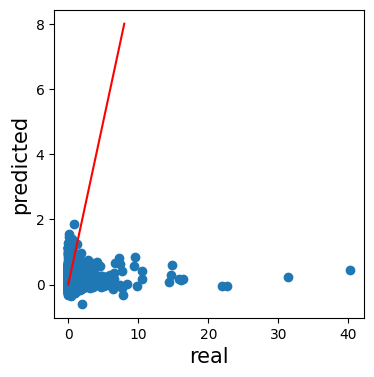

In [47]:
y_predict_cat = cat_regressor.best_estimator_.predict(X_test)

plt.figure(figsize=(4, 4))
plt.scatter(y_test.values, y_predict_cat)
plt.plot([0, 8], [0, 8], 'r')
plt.xlabel('real', fontsize=15)
plt.ylabel('predicted', fontsize=15)
plt.show()

In [48]:
cat_mse = mean_squared_error(y_test, y_predict_cat)
cat_mae = mean_absolute_error(y_test, y_predict_cat)
cat_r2_score = r2_score(y_test, y_predict_cat)
cat_score = cat_regressor.best_estimator_.score(X_test, y_test)

print('mse = {:.5f}'.format(cat_mse))
print('mse = {:.5f}'.format(cat_mae))
print('r2 = {:.5f}'.format(cat_r2_score))
print('score = {:.5f}'.format(cat_score))

mse = 2.43060
mse = 0.51677
r2 = -0.07331
score = -0.07331


# Сравнение моделей

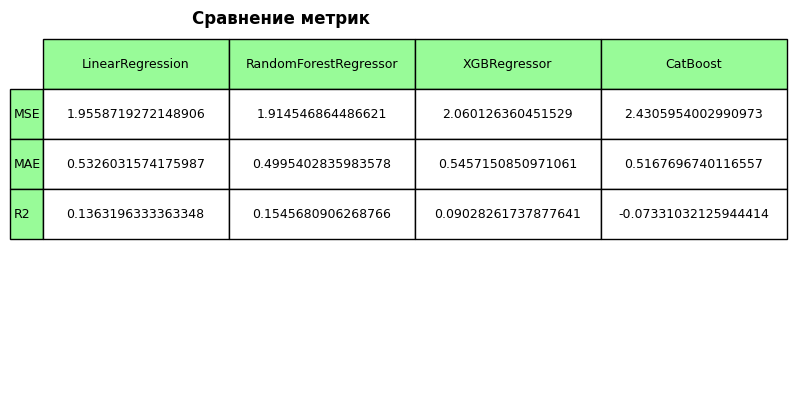

In [49]:
val1 = ["LinearRegression", "RandomForestRegressor", "XGBRegressor", "CatBoost"] 
val2 = ["MSE", "MAE", "R2"] 
val3 = [
    [lr_mse, lr_mae, lr_r2_score],
    [rf_mse, rf_mae, rf_r2_score],
    [xgb_mse, xgb_mae, xgb_r2_score],
    [cat_mse, cat_mae, cat_r2_score]
]

fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table(
    colLabels = val1, 
    rowLabels = val2,  
    cellText = np.array(val3).T,  
    colColours =["palegreen"] * 4,
    rowColours =["palegreen"] * 3,
    cellLoc ='center',  
    loc ='upper left'
)

   
ax.set_title('Сравнение метрик', fontweight ="bold") 
table.scale(1.5, 3)

plt.show() 

# Важность признаков

In [51]:
df_cat = pd.get_dummies(df[cat], columns=cat, drop_first=True)

In [55]:
features =  list(itertools.chain(num, full_pipeline.transformers_[1][1][1].get_feature_names_out()))
print(X_res.shape)
print(len(features))

(13277, 571)
571


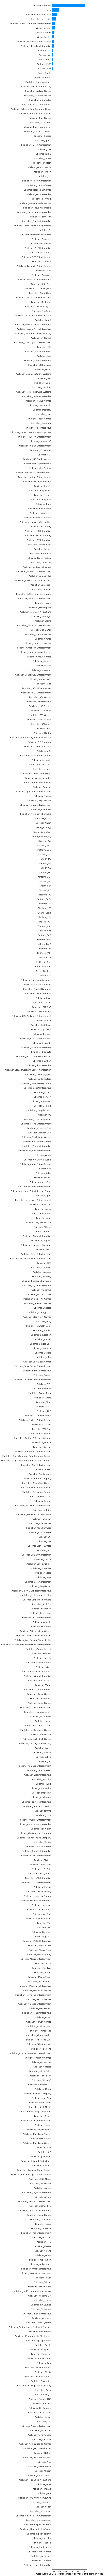

In [54]:
shap_values = shap.TreeExplainer(clf_xgb.best_estimator_).shap_values(X_res)
shap.summary_plot(shap_values, features=X_res, feature_names=features, max_display=X_res.shape[1], plot_type='bar')